In [1]:
comment = 'calculated in Plots_ExpVis_synth.ipynb'

In [2]:
%matplotlib inline
#%matplotlib notebook
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from HigherOrderPathGenerator import CrossValidation_HigherOrderPathGenerator
from Embedding import HON_DeepWalk_Embedding, HONEM_Embedding, HON_NetMF_Embedding, HON_GraRep_Embedding, HON_Transition_Hierarchical_Embedding
from SyntheticNetworks import create_lattice_2nd_order_dynamic
from Visualizations import Visualization, EmbeddingView, Lattice2D_EmbeddingView

In [4]:
size = 10
omega = 0.5
latgen = create_lattice_2nd_order_dynamic(size, omega, lattice_sep='-', check=True)
latgen_FON = create_lattice_2nd_order_dynamic(size, omega=0, lattice_sep='-', check=True)
latgen_FON._id += ' (FON)'

[]
[]
[]
[]


In [5]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')

In [6]:
def disp_pmi_row(emb, node='5-5', title=None, vmax=None, figureargs=dict()):
    key_str = emb.key2str(node) if emb._symmetric else emb.path2str((node,))
    row = np.resize(emb.PMI.loc[key_str].values, (size,size)).T
    fig = plt.figure(**figureargs)
    ax = sns.heatmap(row, annot=True, cmap=plt.cm.Blues, ax=fig.gca(), vmin=0, vmax=vmax)
    ax.invert_yaxis()
    if title is not None:
        fig.suptitle(title)
    return fig

In [7]:
def get_stretch_ratio(emb, edge_distance = 1):
    ev = Lattice2D_EmbeddingView(emb, use_source=True, edge_distance=edge_distance)
    hor_edges_len = np.linalg.norm(ev.node_embedding_diff(ev._hor_edge_pairs),axis=1)
    ver_edges_len = np.linalg.norm(ev.node_embedding_diff(ev._ver_edge_pairs),axis=1)
    return ver_edges_len.mean()/hor_edges_len.mean() # = ev.config['stretch']

## NetMF(1) - pairwise

In [8]:
emb_N1_pairs = HON_NetMF_Embedding(latgen, 128, pairwise=True)
%time emb_N1_pairs.train(window_size=1, negative=1, optimized=True)
print('effective dimension', emb_N1_pairs.dimension)

Wall time: 21.9 ms
effective dimension 100


paths: Lattice2D(10, omega=0.500000)
embedding: NetMF_pairs_source
dim: (100, 7)
embedding columns: ['x', 'y']
other columns: ['direction', 'key_len', 'parity', 'x_orig', 'y_orig']

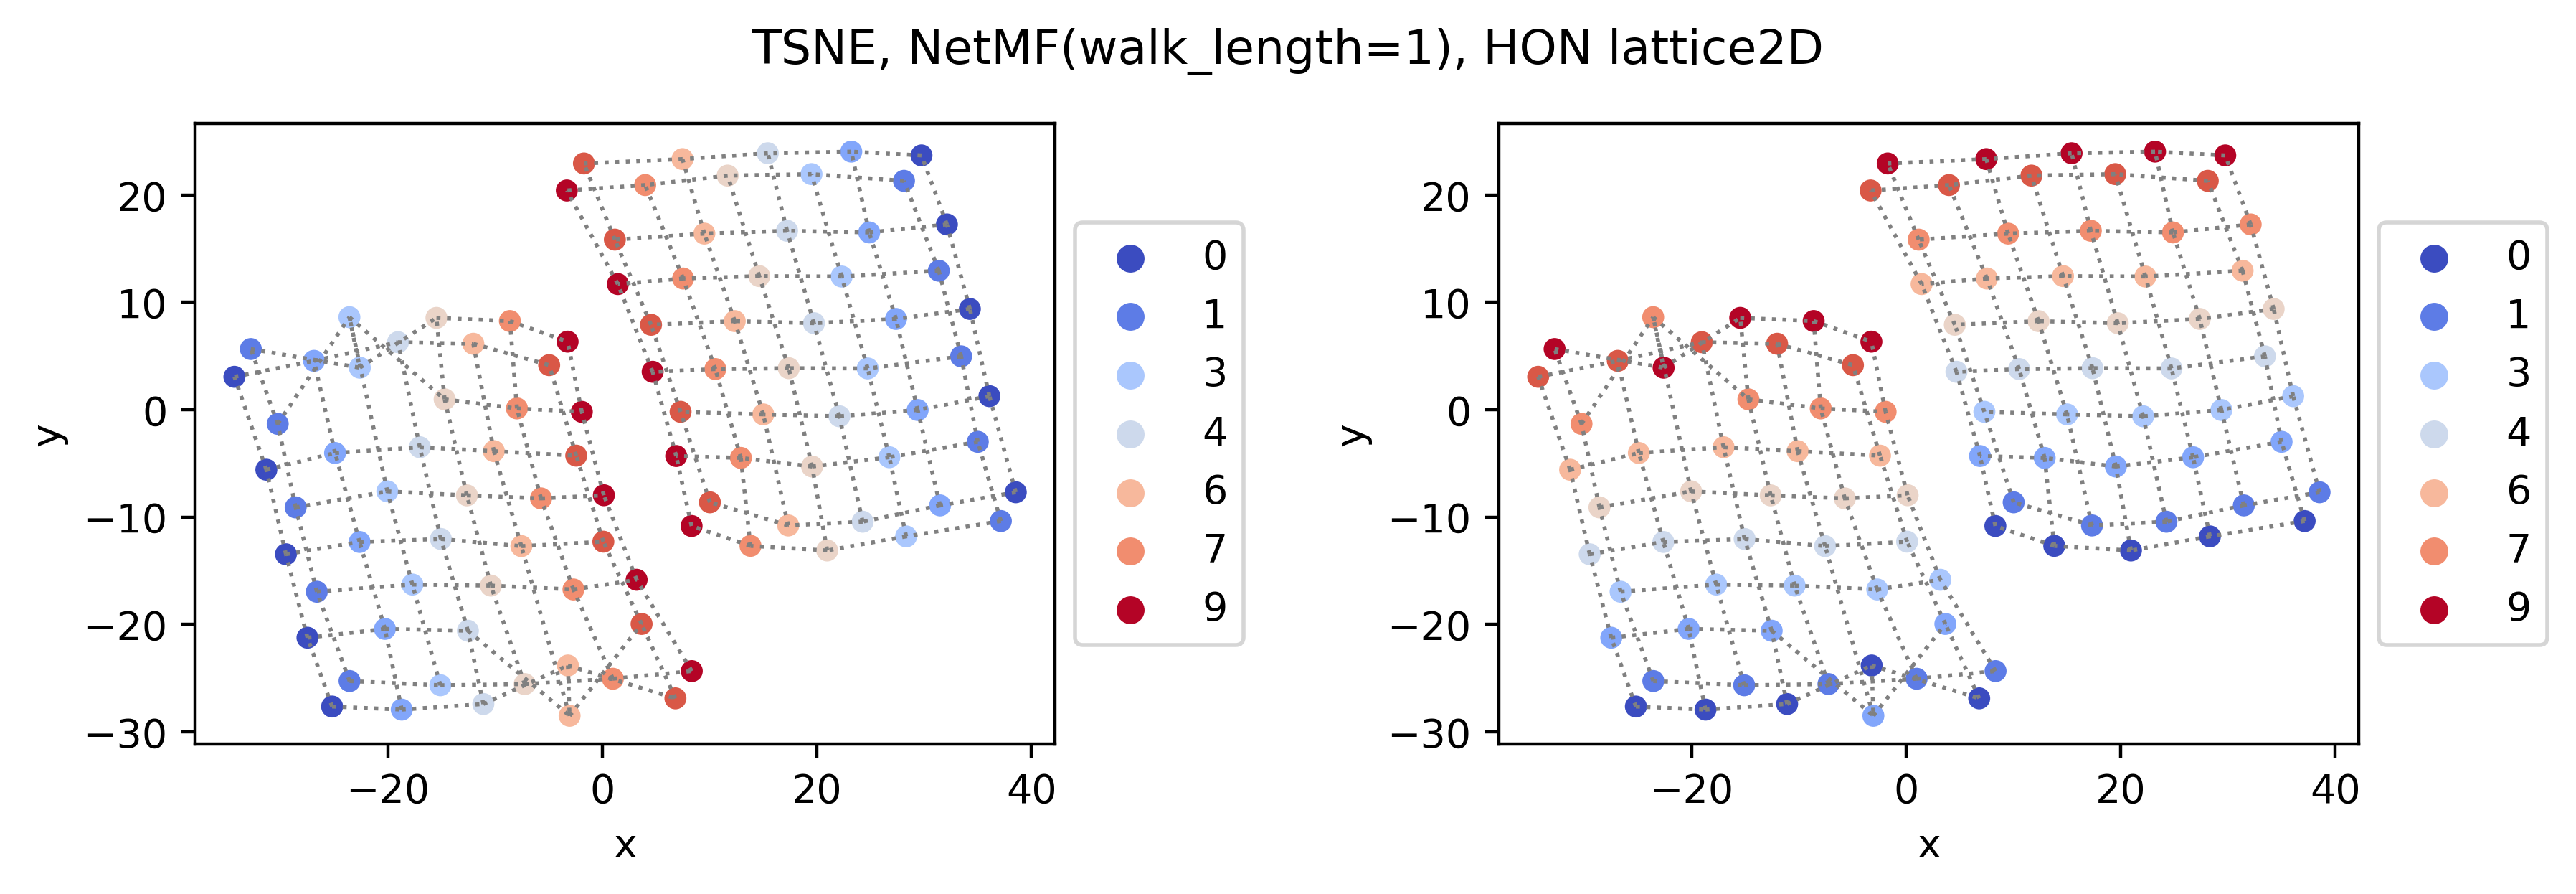

In [9]:
ev_N1_pairs = Lattice2D_EmbeddingView(emb_N1_pairs, edge_distance=2)
vis_N1_pairs = ev_N1_pairs.visualize_TSNE(random_state=33, n_iter=2000, n_iter_without_progress=500, title='TSNE, NetMF(walk_length=1), HON lattice2D')
vis_N1_pairs.plot2(figsize=(9,3), dpi=400) # plot not shown in thesis
vis_N1_pairs

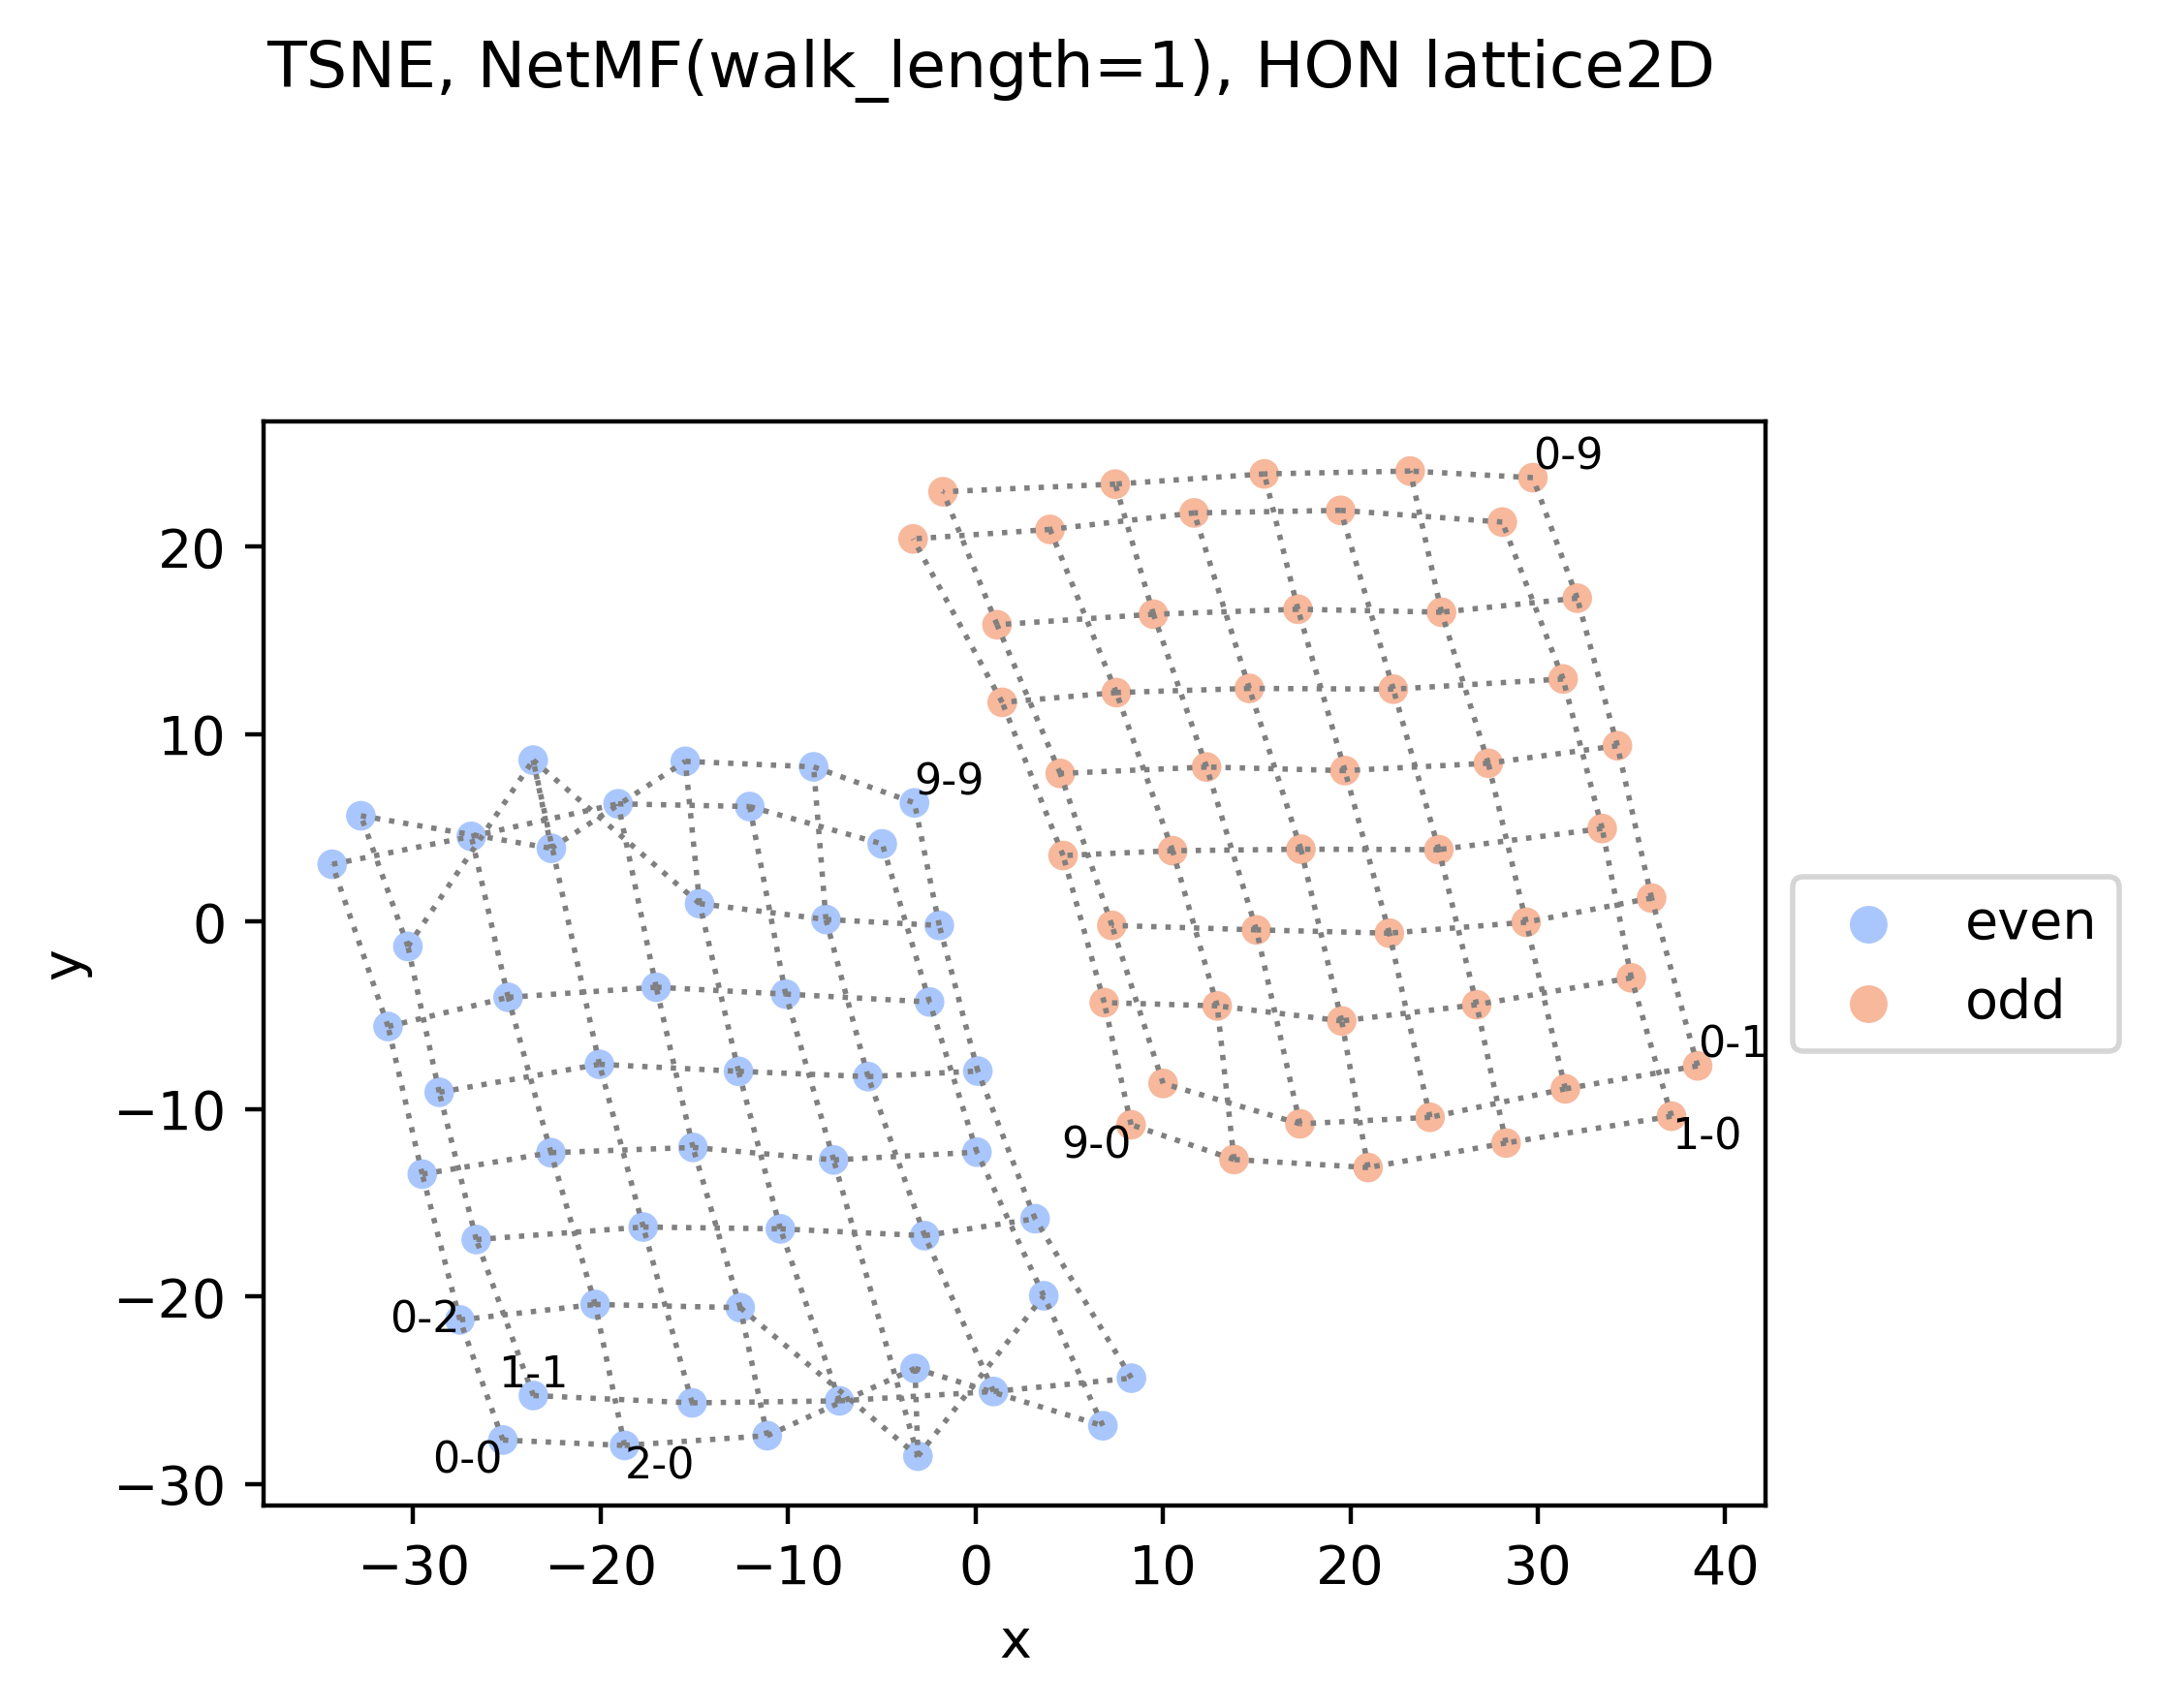

In [10]:
vis_N1_pairs.plot1(figsize=(5,5), dpi=400, hue='parity')
vis_N1_pairs.annotate_node('0-0', ha='right', va='top')
vis_N1_pairs.annotate_node('1-1', ha='center', va='bottom')
vis_N1_pairs.annotate_node('0-2', ha='right', va='center')
vis_N1_pairs.annotate_node('2-0', ha='left', va='top')
vis_N1_pairs.annotate_node('9-9', ha='left', va='bottom')
vis_N1_pairs.annotate_node('0-1', ha='left', va='bottom')
vis_N1_pairs.annotate_node('1-0', ha='left', va='top')
vis_N1_pairs.annotate_node('0-9', ha='left', va='bottom')
vis_N1_pairs.annotate_node('9-0', ha='right', va='top')
##vis_N1_pairs.save_describe('tmp/tsne_netmf-one_synth_parity.png', comment) 
# plot not shown in thesis

In [11]:
# find a random state
if False:
    ev = ev_N1_pairs
    for x in range(20):
        vis = ev.visualize_TSNE(random_state=x, n_iter=2000, edge_distance=2)
        vis.plot2(figsize=(9,4), dpi=400)

## PMI for NetMF and different window_sizes
Figure 4.3

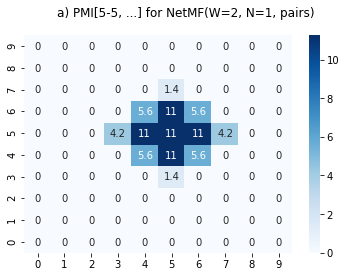

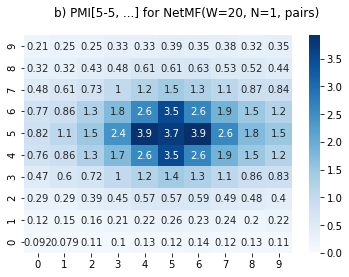

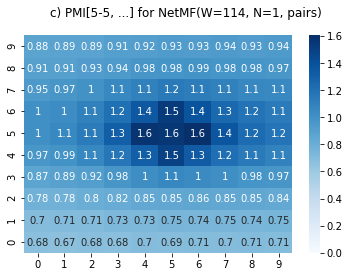

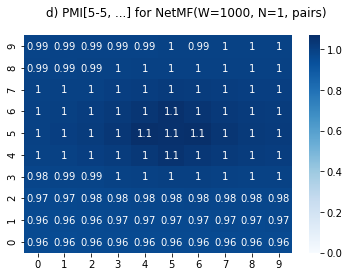

In [12]:
node='5-5'
if True:
    letters = list('abcd')
    info, figures = dict(), dict()
    for window_size in [2,20,114,1000]:
        emb = HON_NetMF_Embedding(latgen, dimension=16, pairwise=True)
        emb.train(window_size=window_size, negative=1)
        title = f'{letters.pop(0)}) PMI[{node}, ...] for NetMF(W={emb._window_size}, N={emb._training_config["negative"]}, pairs)'
        #title = f"{letters.pop(0)}) window_size={window_size} PMI[{node},...]"
        figures[window_size] = disp_pmi_row(emb, node, title) # , vmax=11
        info[f"stretch[{window_size}]"] = get_stretch_ratio(emb)
    for window_size,fig in figures.items():
         fig.savefig('tmp/pmi_NetMF_synth_W%d.png'%window_size, bbox_inches='tight')
    with open('tmp/pmi_NetMF_synth.txt', 'w') as f:
        emb.write_config(f, comment=comment, prefix='', sep='\t')

## HONEM and direct competitors


In [13]:
emb_H = HONEM_Embedding(latgen, 16)
%time emb_H.train()
print('effective dimension', emb_H.dimension)

Wall time: 23.9 ms
effective dimension 16


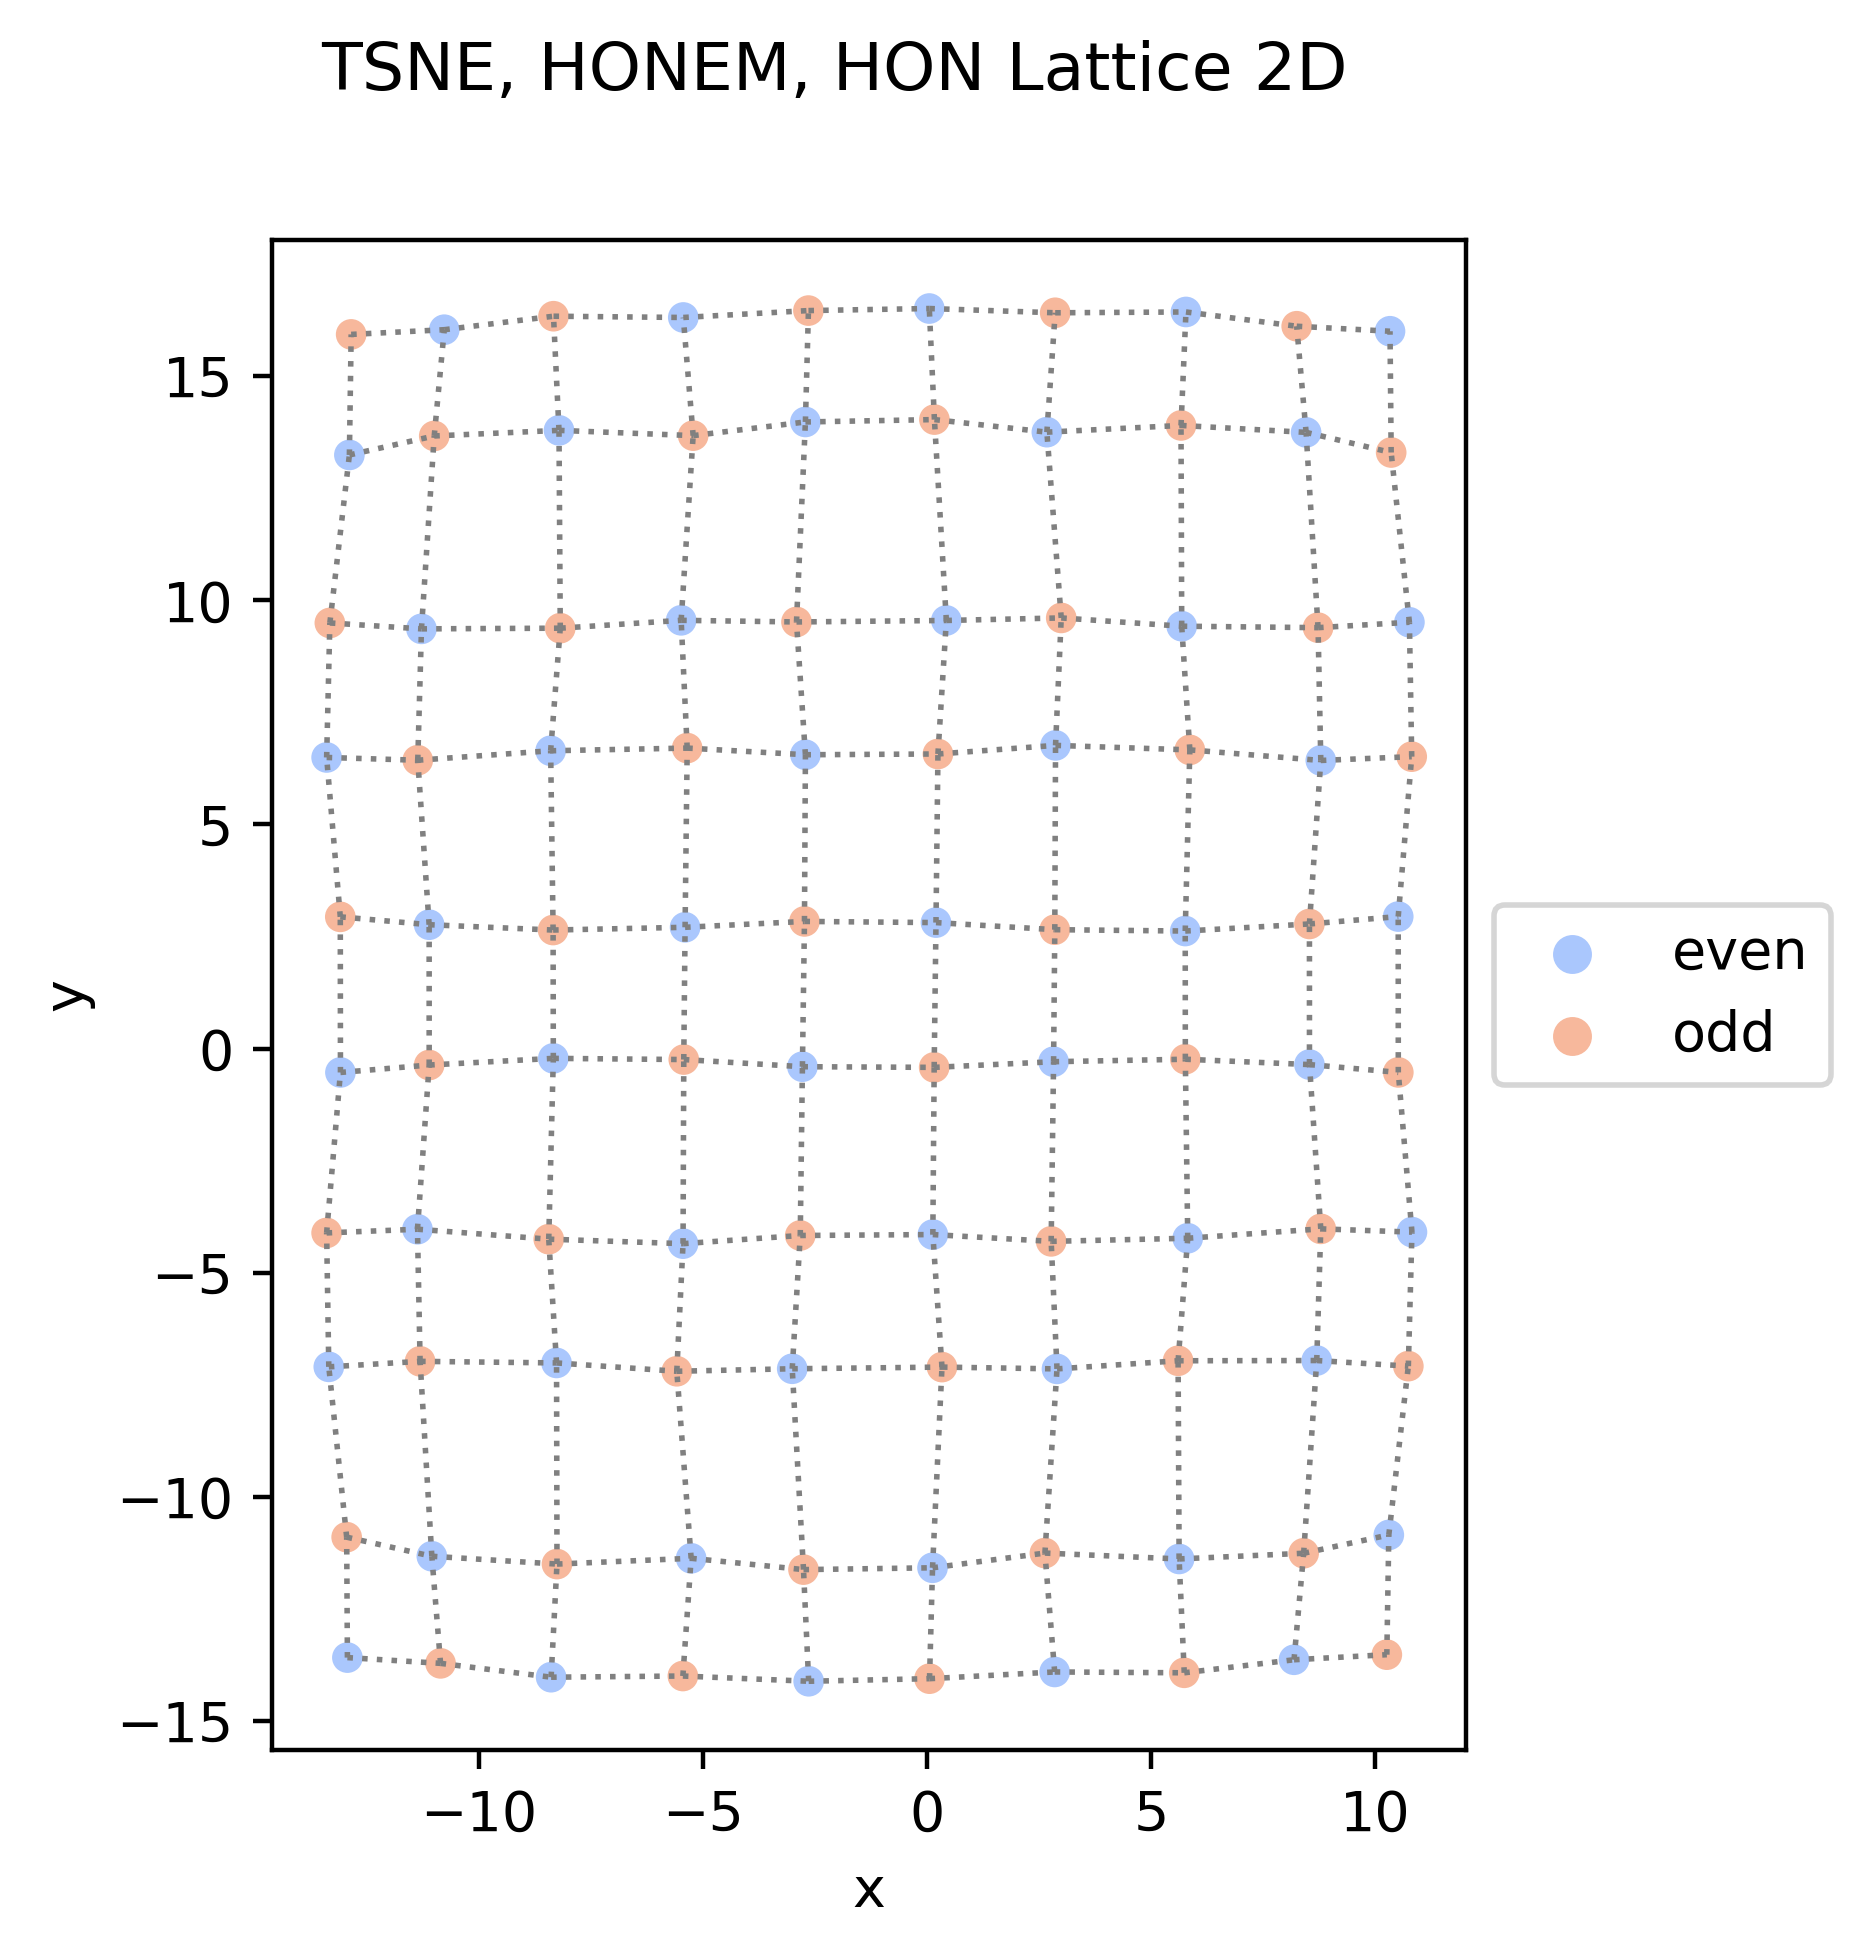

In [14]:
ev_H = Lattice2D_EmbeddingView(emb_H, edge_distance=1)
vis_H = ev_H.visualize_TSNE(random_state=17, n_iter=1000, title='TSNE, HONEM, HON Lattice 2D')
vis_H.plot1(figsize=(7,5), dpi=400, hue='parity')
vis_H.save_describe('tmp/tsne_HONEM_synth_parity.png', comment) # figure 4.6 (right)

paths: Lattice2D(10, omega=0.500000)
embedding: HONEM_source
dim: (180, 4)
embedding columns: ['len', 'angle']
other columns: ['angle360', 'direction']

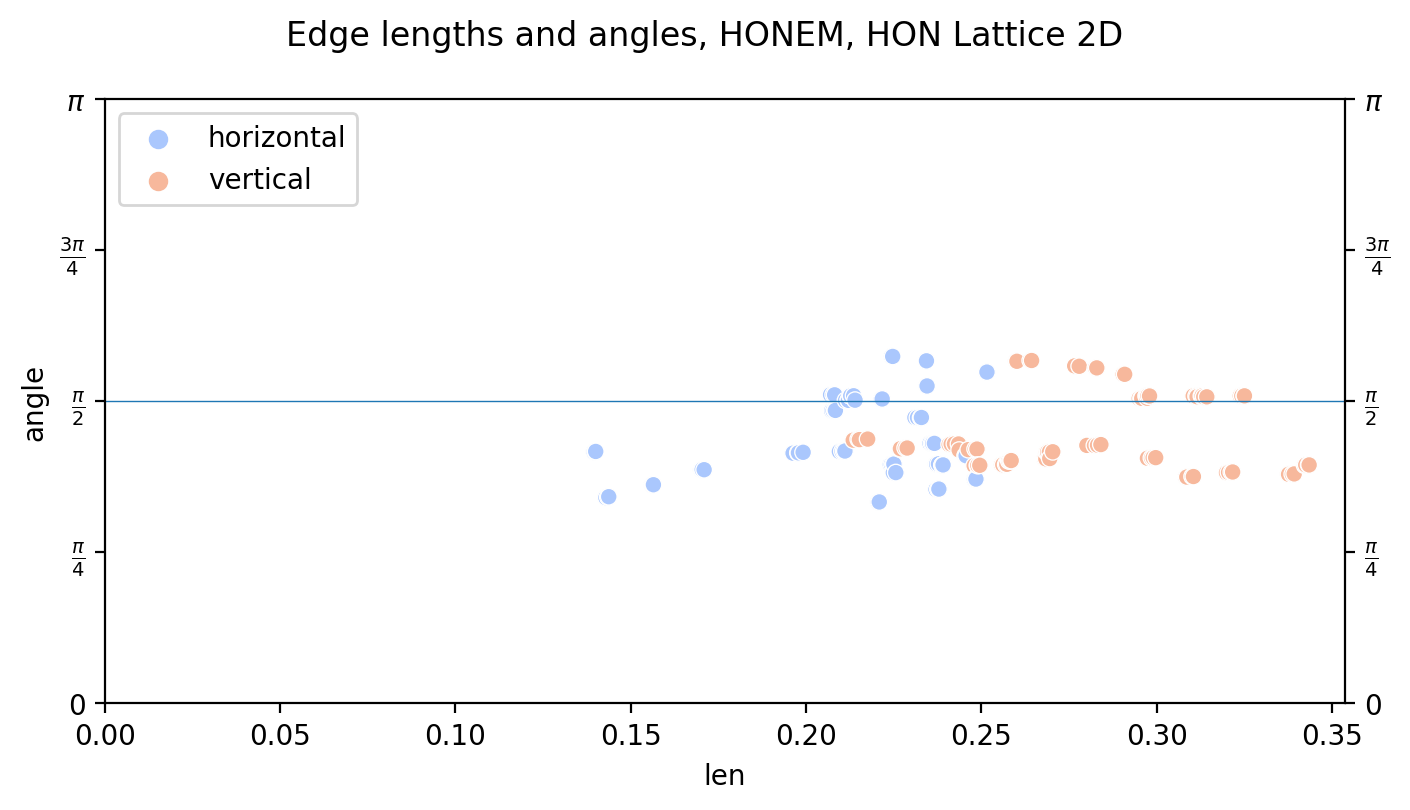

In [15]:
ev_H.visualize_edges_len_angle(title='Edge lengths and angles, HONEM, HON Lattice 2D',figsize=(8,4))
# plot not shown in thesis

In [16]:
# calculate neighborhood (code from HONEM_Embedding)
neighborhood = emb_H.neighborhood_matrix(1)
if emb_H._gen.max_rule_key_length > 1:
    for order in range(2, emb_H._gen.max_rule_key_length+1):
        neighborhood = neighborhood + math.exp(1-order) * emb_H.neighborhood_matrix(order, sort=False)
# sort
neighborhood = neighborhood.loc[emb_H.source_paths_str]
neighborhood = neighborhood[emb_H.target_nodes_str]
# store neighborhood as PMI for disp_pmi_row()
emb_H.PMI = neighborhood

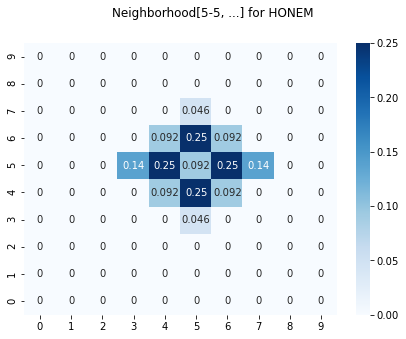

In [17]:
node='5-5'
title = f'Neighborhood[{node}, ...] for HONEM'
fig = disp_pmi_row(emb_H, node, title, figureargs=dict(figsize=(7,5)))
fig.savefig('tmp/neighborhood_HONEM_synth.png', bbox_inches='tight') # figure 4.6 (left)
with open('tmp/neighborhood_HONEM_synth.txt', 'w') as f:
    comment_loc = comment + ('' if comment=='' else '\n\n') + f'stretch\t{get_stretch_ratio(emb_H):f}'
    emb_H.write_config(f, comment=comment_loc, prefix='', sep='\t')

In [18]:
# best NetMF embedding with window_size=2, see Lattice2D_sim.ipynb
emb_N2_pairs = HON_NetMF_Embedding(latgen, 16, pairwise=True)
%time emb_N2_pairs.train(window_size=2, negative=2, optimized=True)
print('effective dimension', emb_N2_pairs.dimension)

Wall time: 14 ms
effective dimension 16


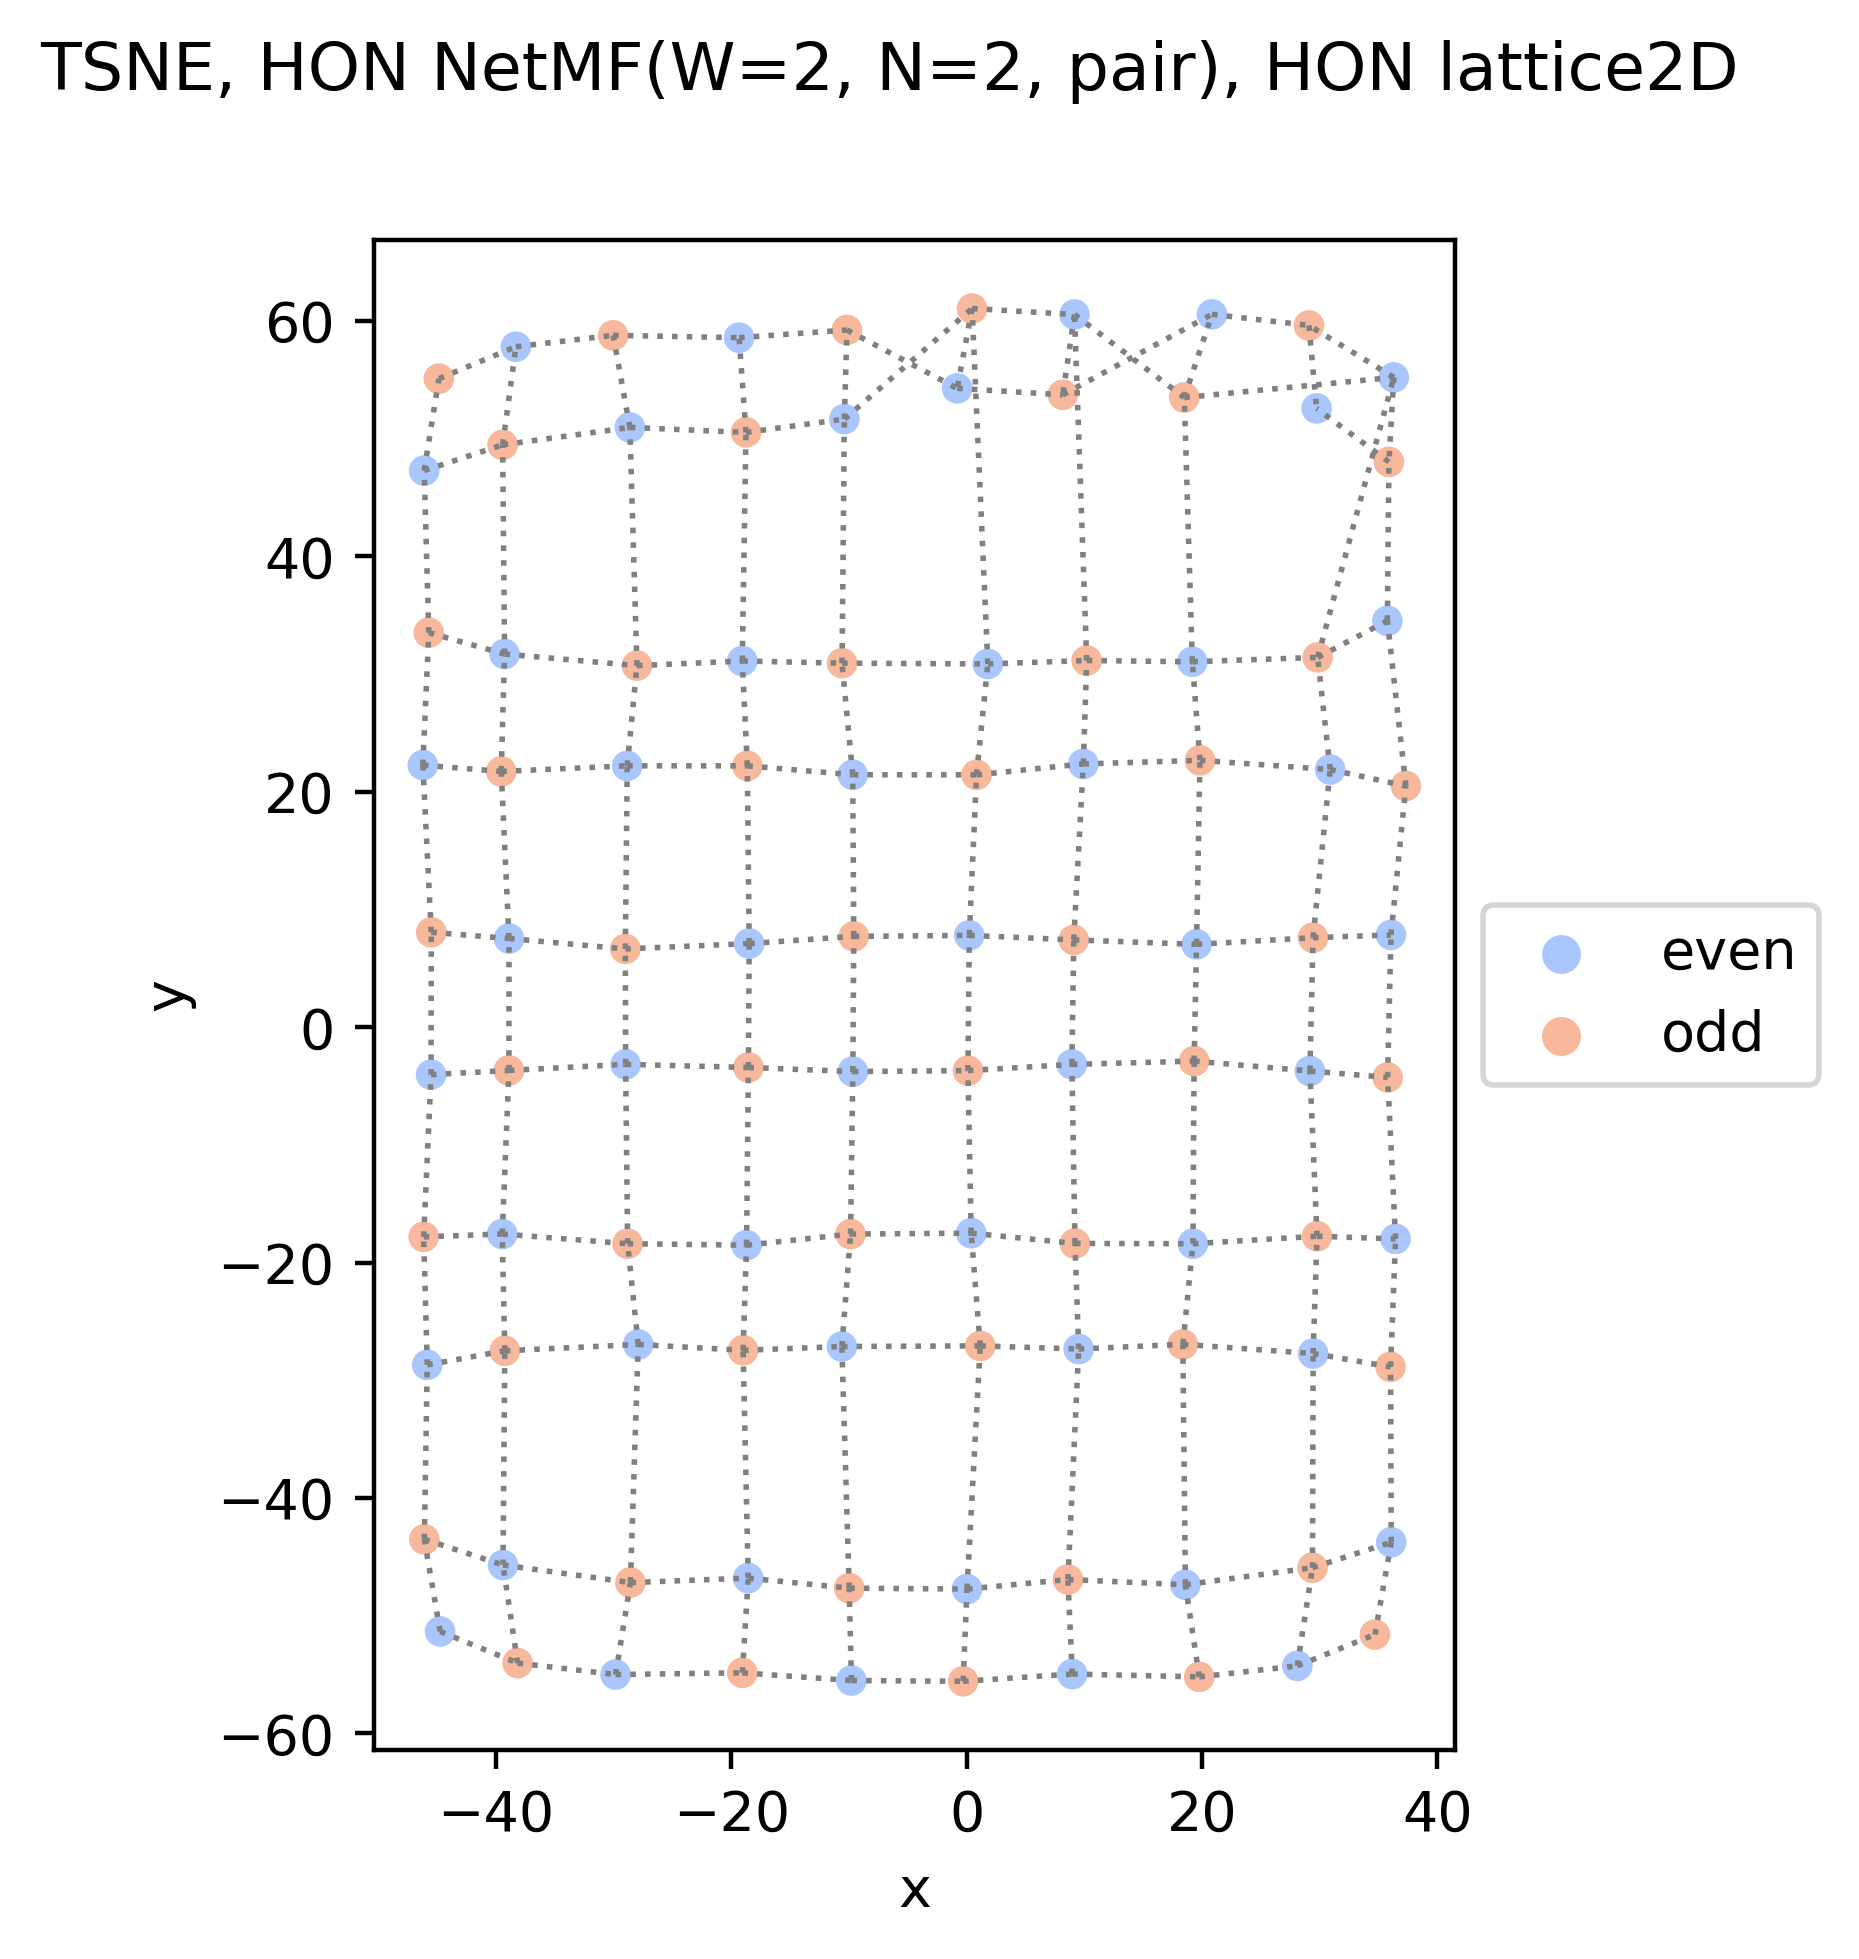

In [19]:
ev_N2_pairs = Lattice2D_EmbeddingView(emb_N2_pairs, use_source=True, edge_distance=1)
vis_N2_pairs = ev_N2_pairs.visualize_TSNE(random_state=4, n_iter=1000, perplexity=20, title='TSNE, HON NetMF(W=2, N=2, pair), HON lattice2D')
vis_N2_pairs.plot1(figsize=(5,5), dpi=400, hue='parity')
vis_N2_pairs.save_describe('tmp/tsne_netmf-w2n2_synth_parity.png', comment) # figure 4.2 (top, right)

max_key_len 1
average horizontal edge length 0.6305398901368542
average vertical edge length 0.8431255282928984
ratio 0.7478600386036551


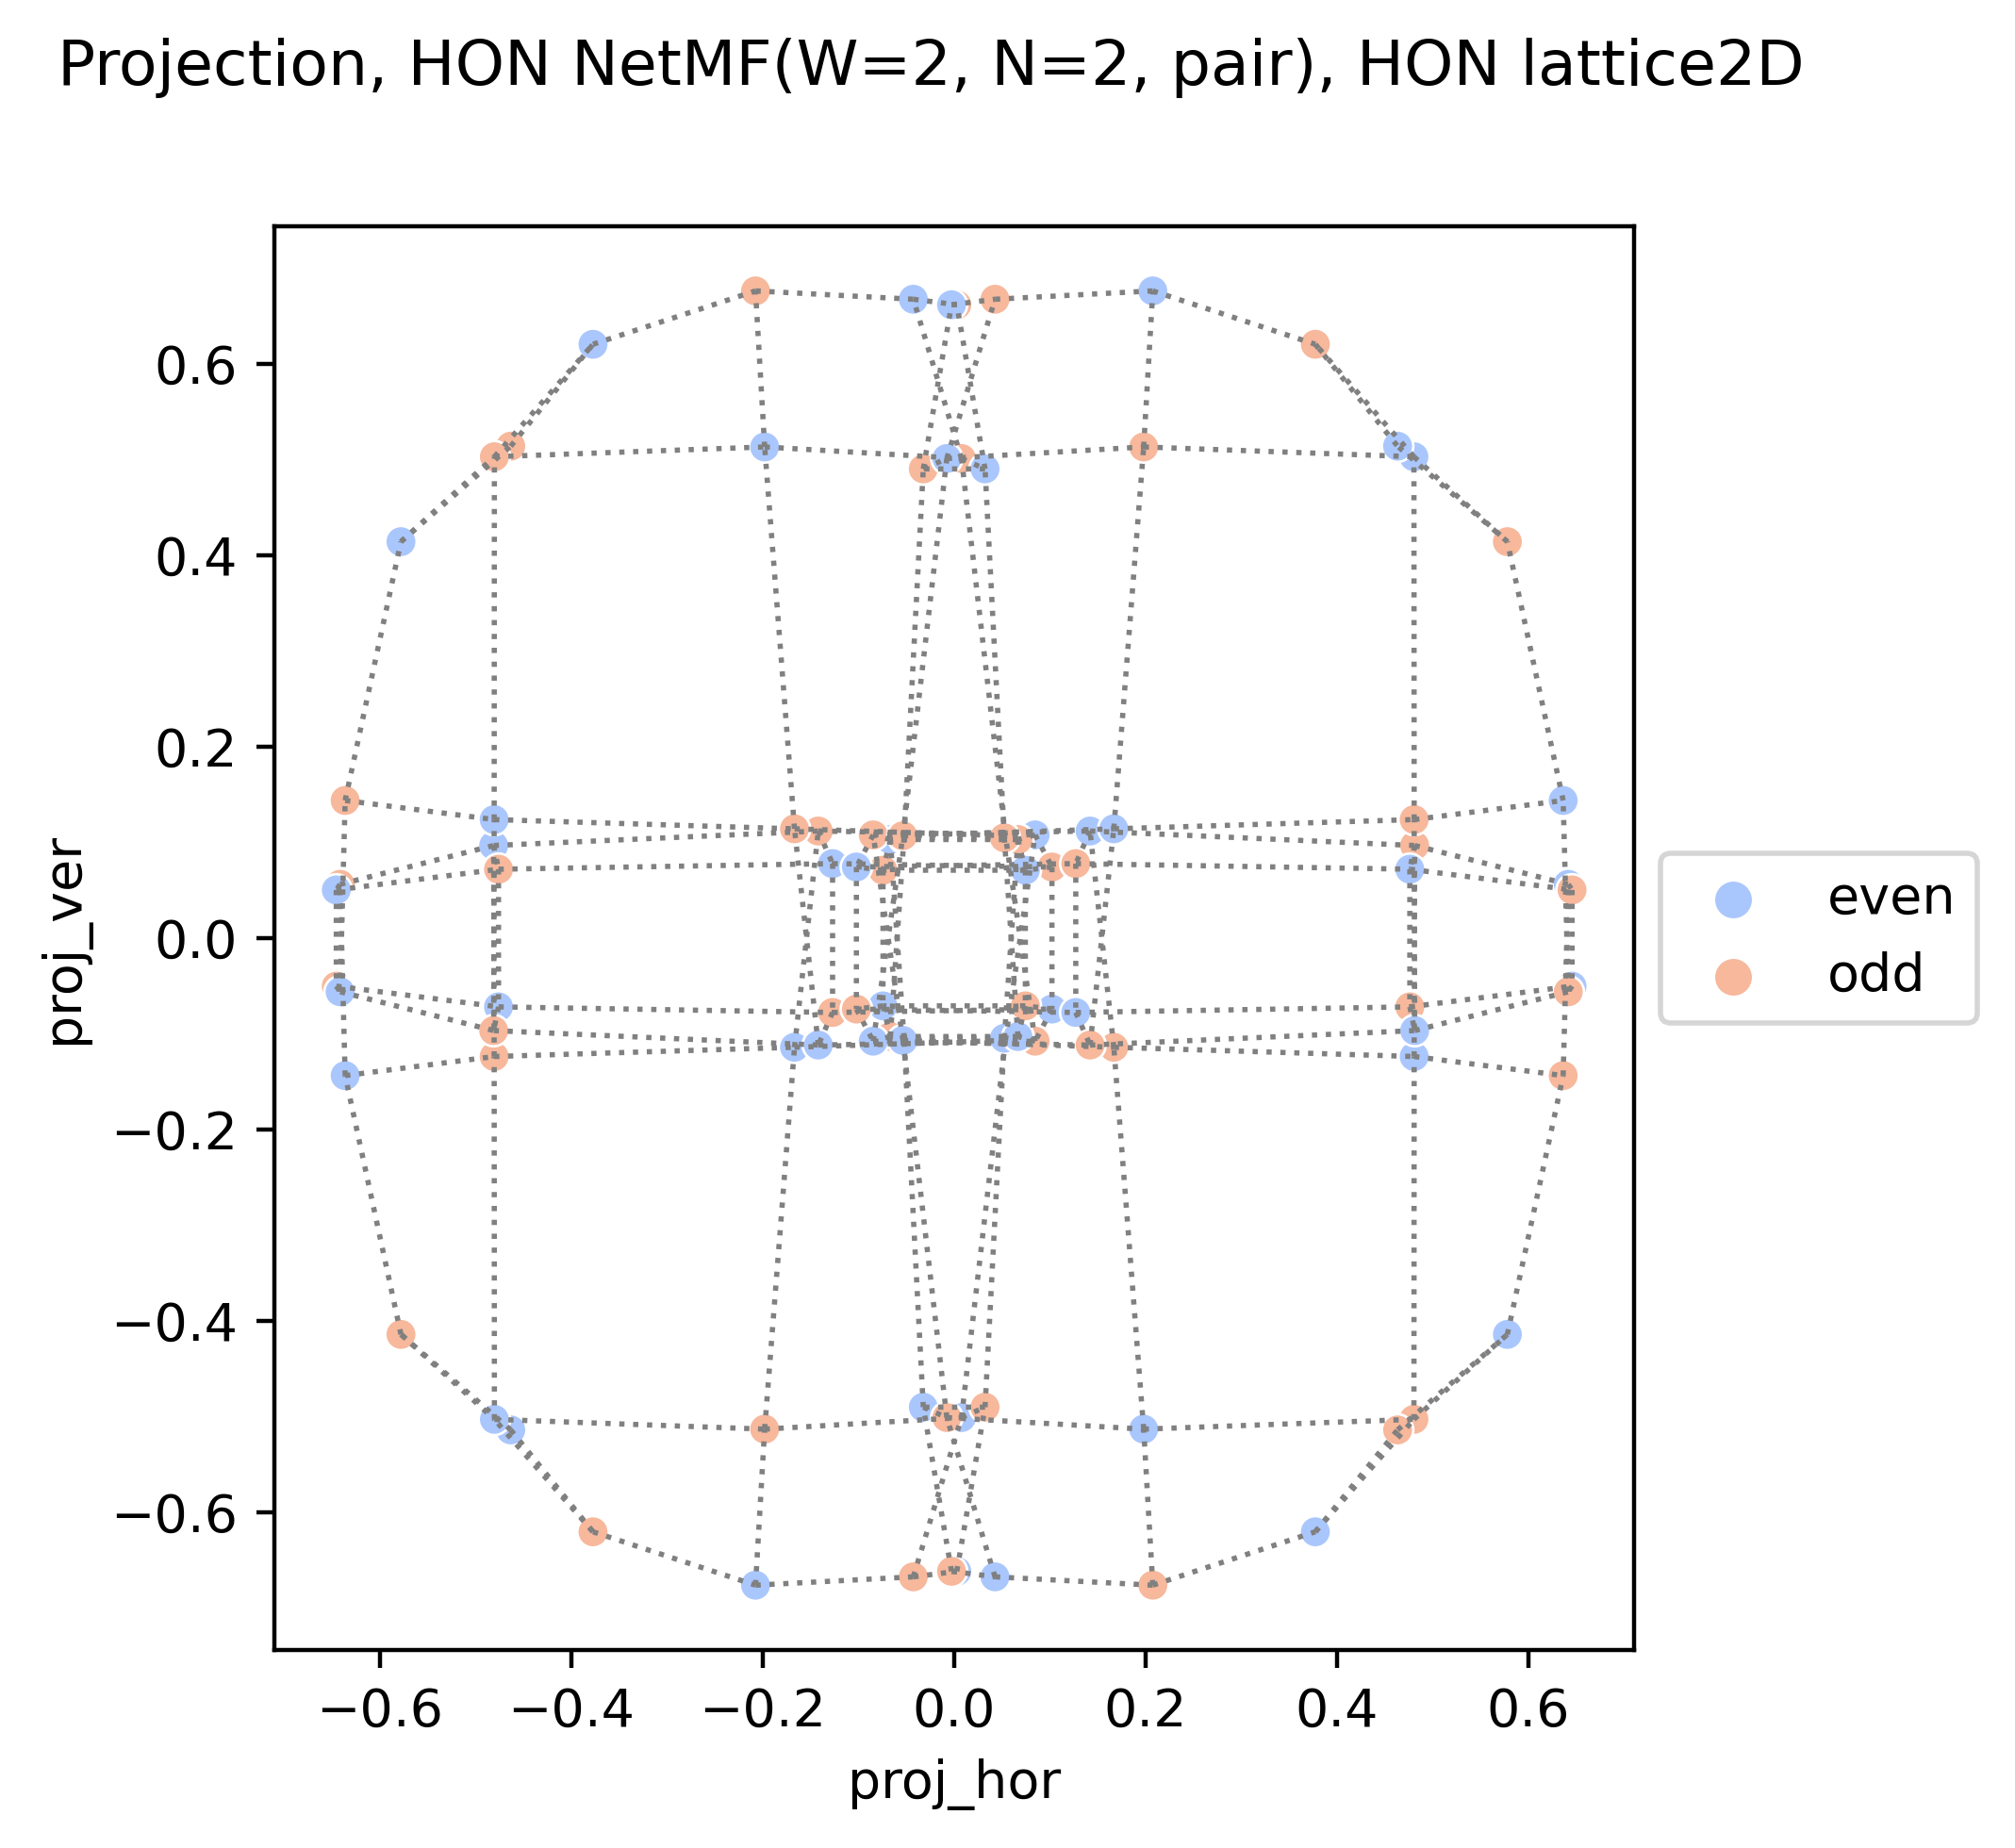

In [20]:
vis_N2_pairs_proj = ev_N2_pairs.visualize_proj(title='Projection, HON NetMF(W=2, N=2, pair), HON lattice2D')
vis_N2_pairs_proj.plot1(figsize=(5,5), dpi=400, hue='parity')
vis_N2_pairs_proj.save_describe('tmp/proj_netmf-w2n2_synth_parity.png', comment) # figure 3.3 (right)

In [21]:
emb_N2_pairs_FON = HON_NetMF_Embedding(latgen_FON, 16, pairwise=True)
%time emb_N2_pairs_FON.train(window_size=2, negative=2, optimized=True)
print('effective dimension', emb_N2_pairs_FON.dimension)

Wall time: 11 ms
effective dimension 16


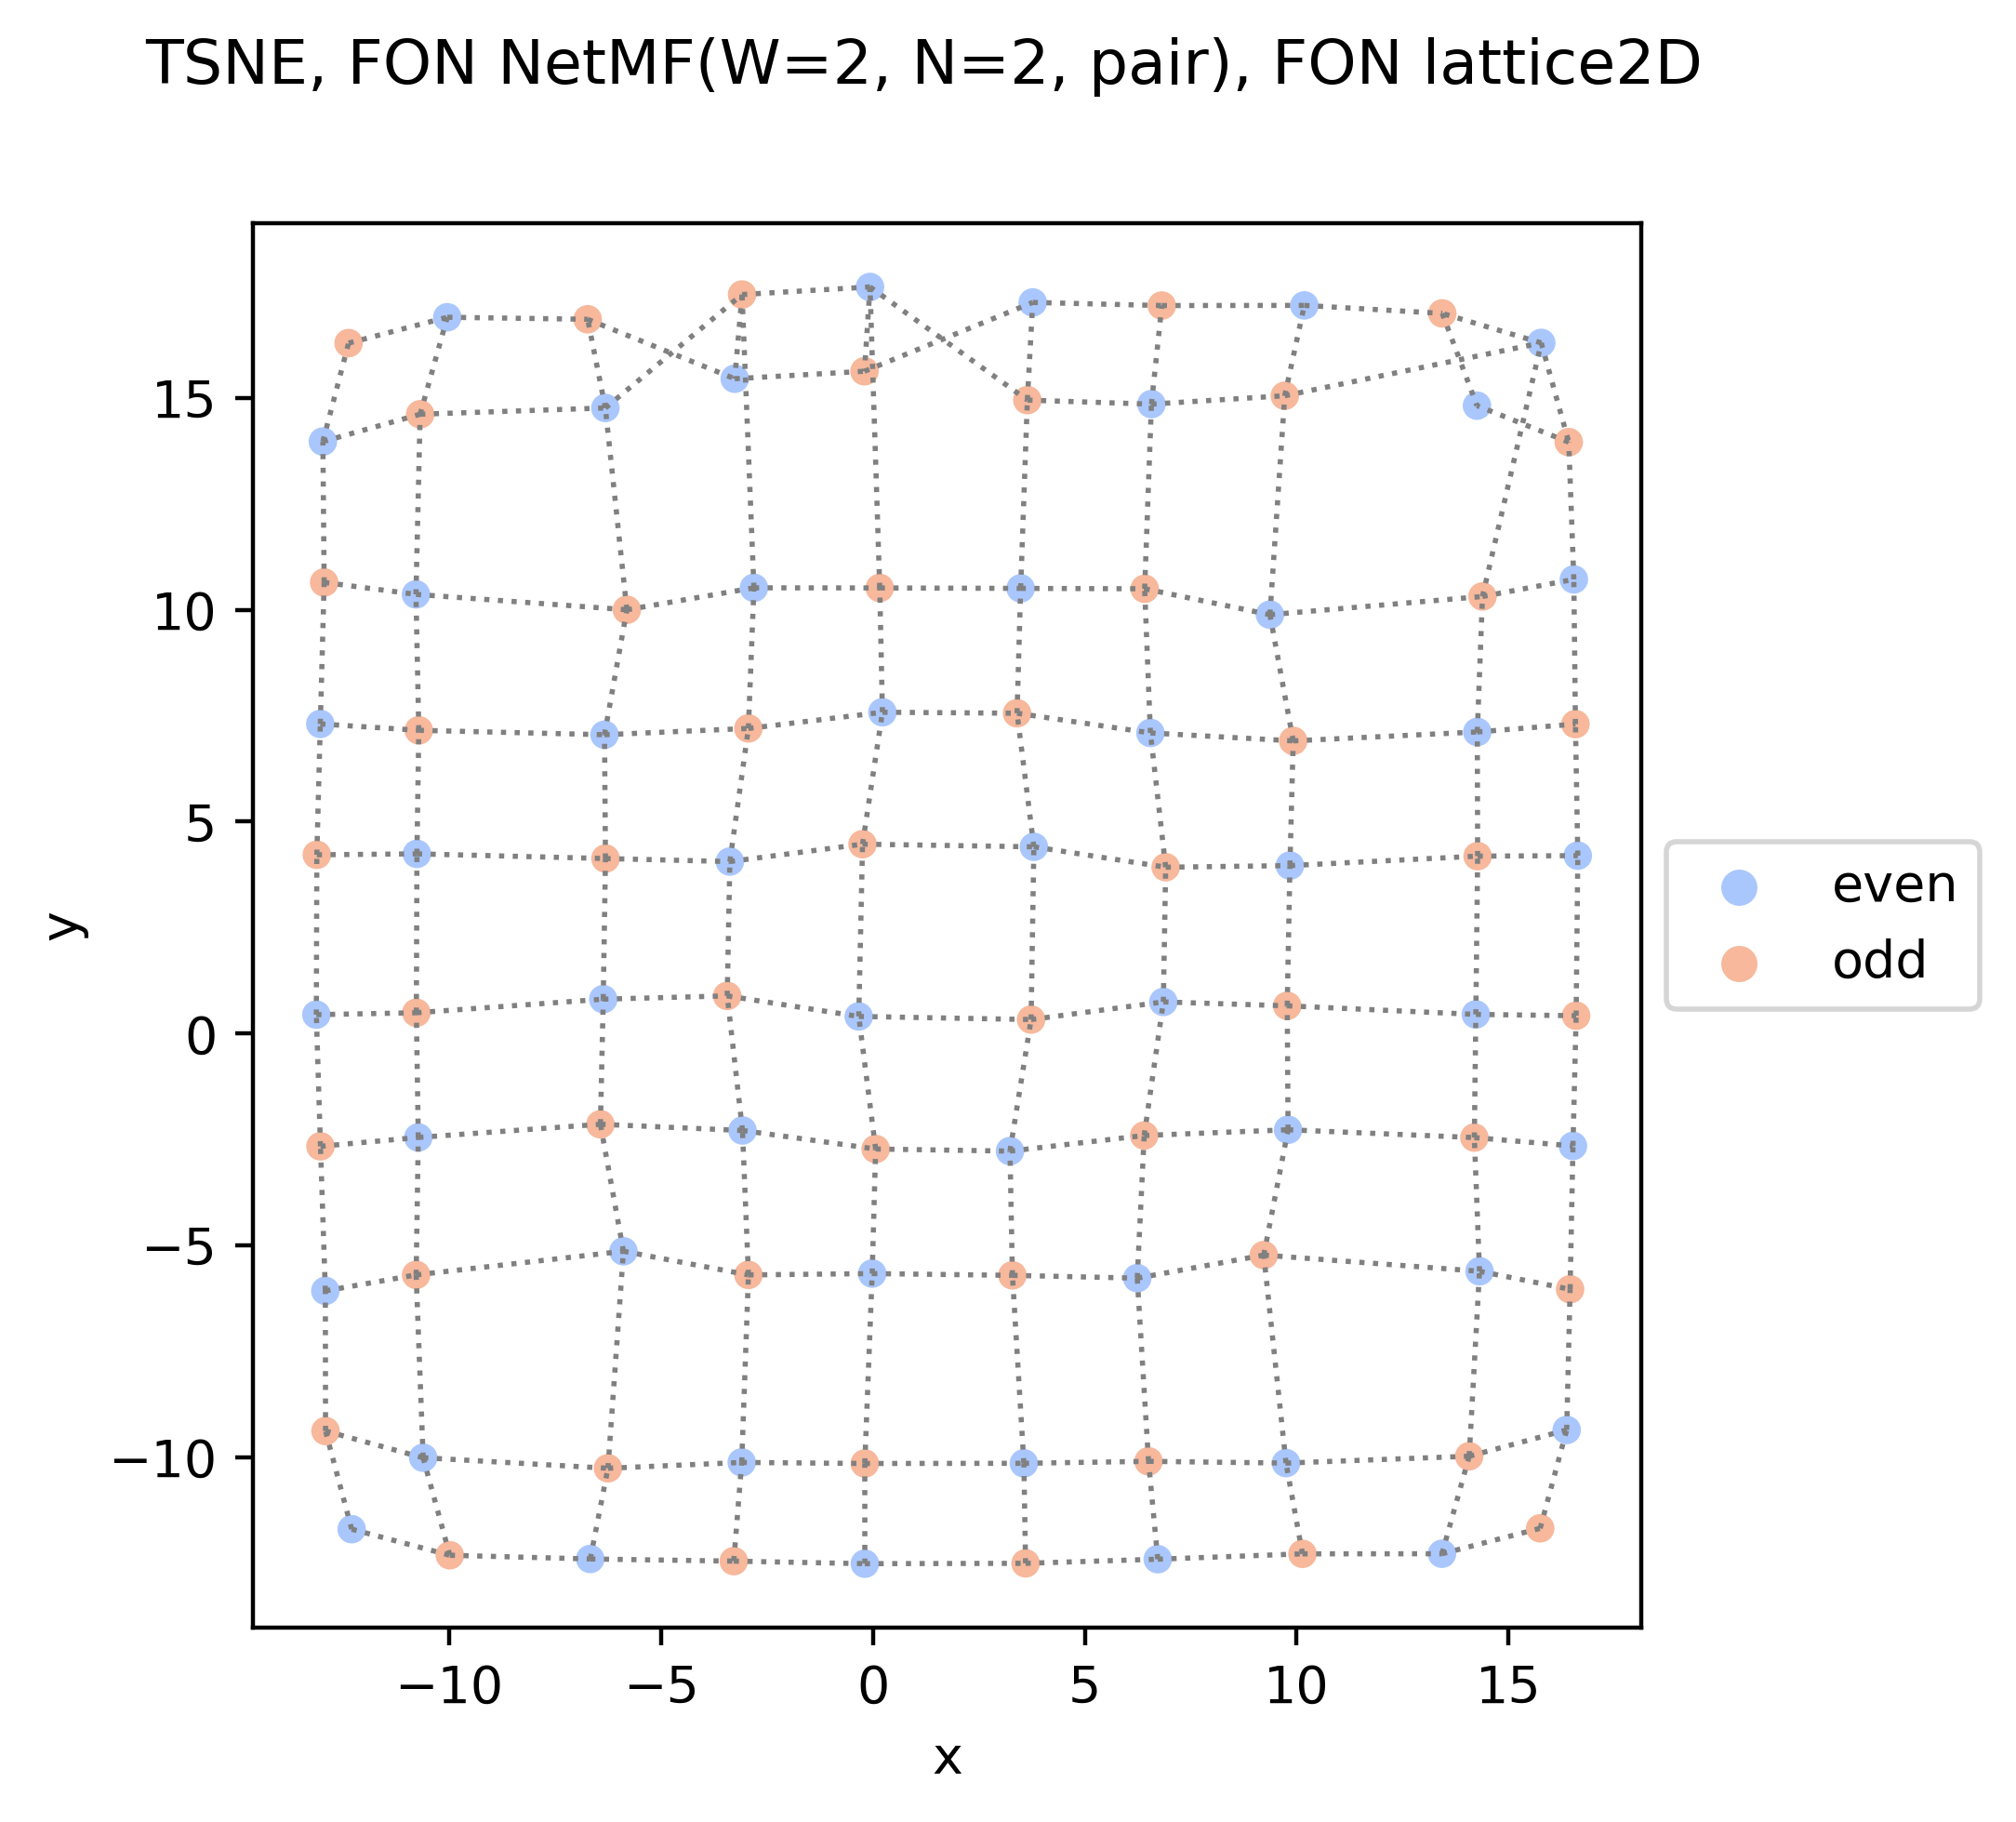

In [22]:
ev_N2_pairs_FON = Lattice2D_EmbeddingView(emb_N2_pairs_FON, use_source=True, edge_distance=1)
vis_N2_pairs_FON = ev_N2_pairs_FON.visualize_TSNE(random_state=8, n_iter=1000, title='TSNE, FON NetMF(W=2, N=2, pair), FON lattice2D')
vis_N2_pairs_FON.plot1(figsize=(5,5), dpi=400, hue='parity')
vis_N2_pairs_FON.save_describe('tmp/fon_tsne_netmf-w2n2_synth_parity.png', comment) # figure 4.2 (top, left)

In [23]:
# best GraRep embedding with window_size=2, see Lattice2D_sim.ipynb
emb_G2_pairs = HON_GraRep_Embedding(latgen, 16, num_steps=2, pairwise=True)
%time emb_G2_pairs.train(negative=3)
print('effective dimension', emb_G2_pairs.dimension)

Wall time: 14 ms
effective dimension 32


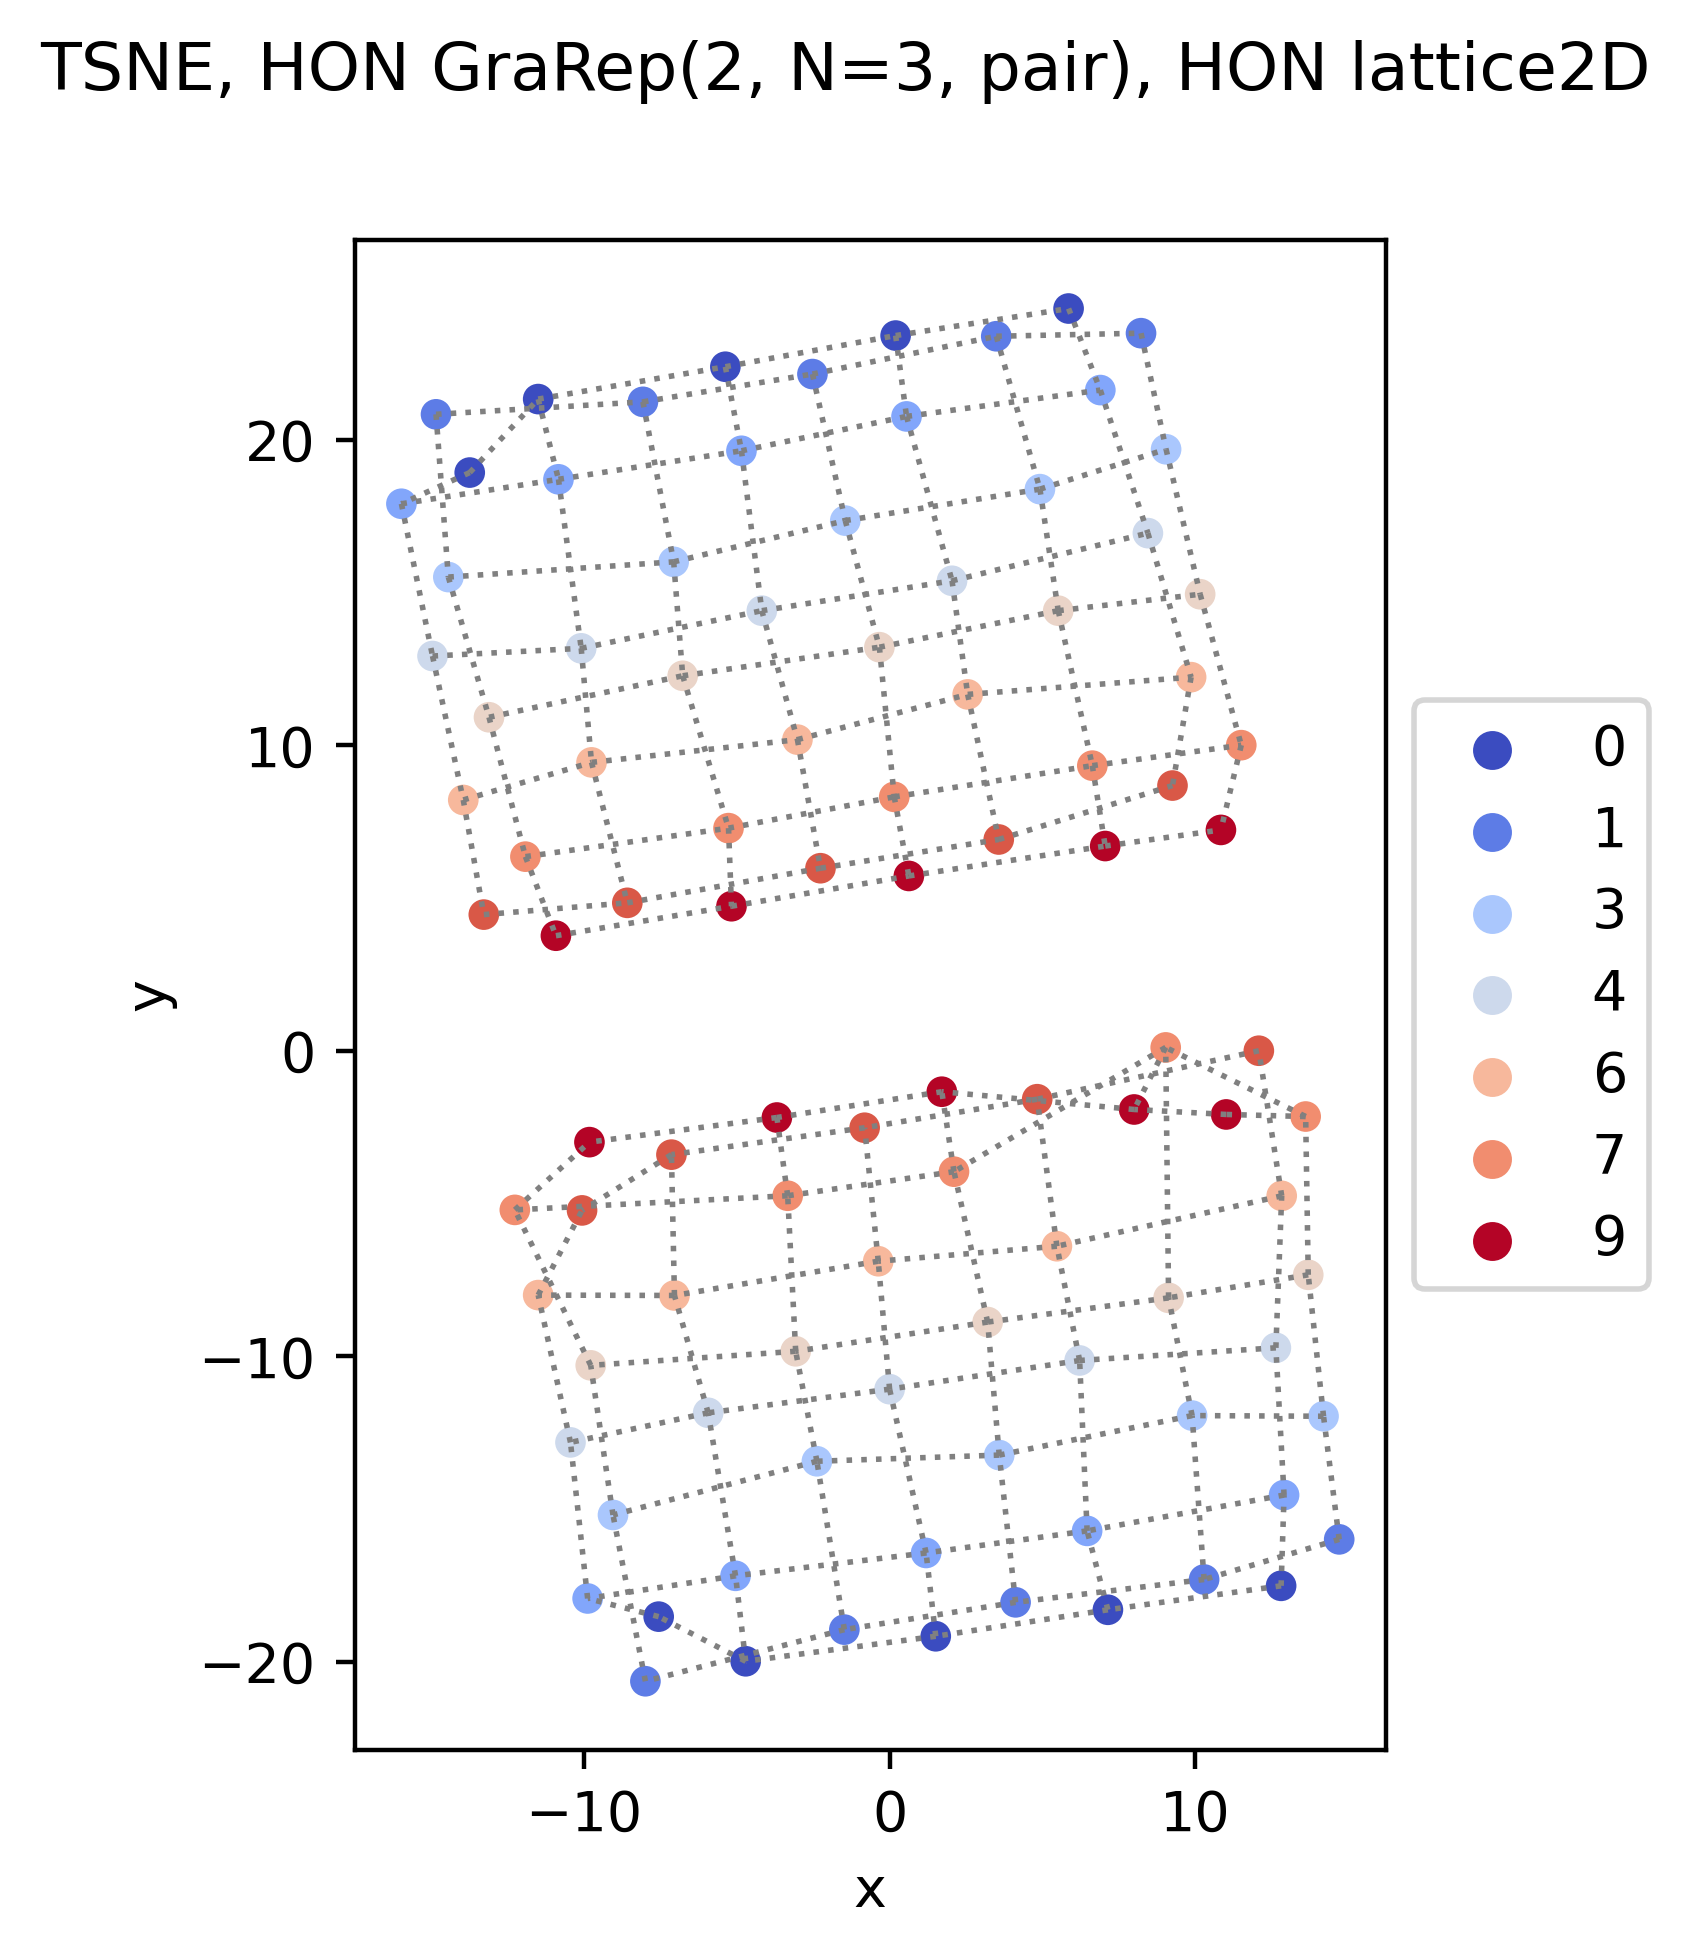

In [24]:
ev_G2_pairs = Lattice2D_EmbeddingView(emb_G2_pairs, use_source=True, edge_distance=2)
vis_G2_pairs = ev_G2_pairs.visualize_TSNE(random_state=4, n_iter=1000, title='TSNE, HON GraRep(2, N=3, pair), HON lattice2D')
vis_G2_pairs.plot1(figsize=(5,5), dpi=400, hue='x_orig')
vis_G2_pairs.save_describe('tmp/tsne_grarep-w2n3_synth_x.png', comment) # figure 4.2 (center, right)

In [25]:
emb_G2_pairs_FON = HON_GraRep_Embedding(latgen_FON, 16, num_steps=2, pairwise=True)
%time emb_G2_pairs_FON.train(negative=3)

Wall time: 26.9 ms


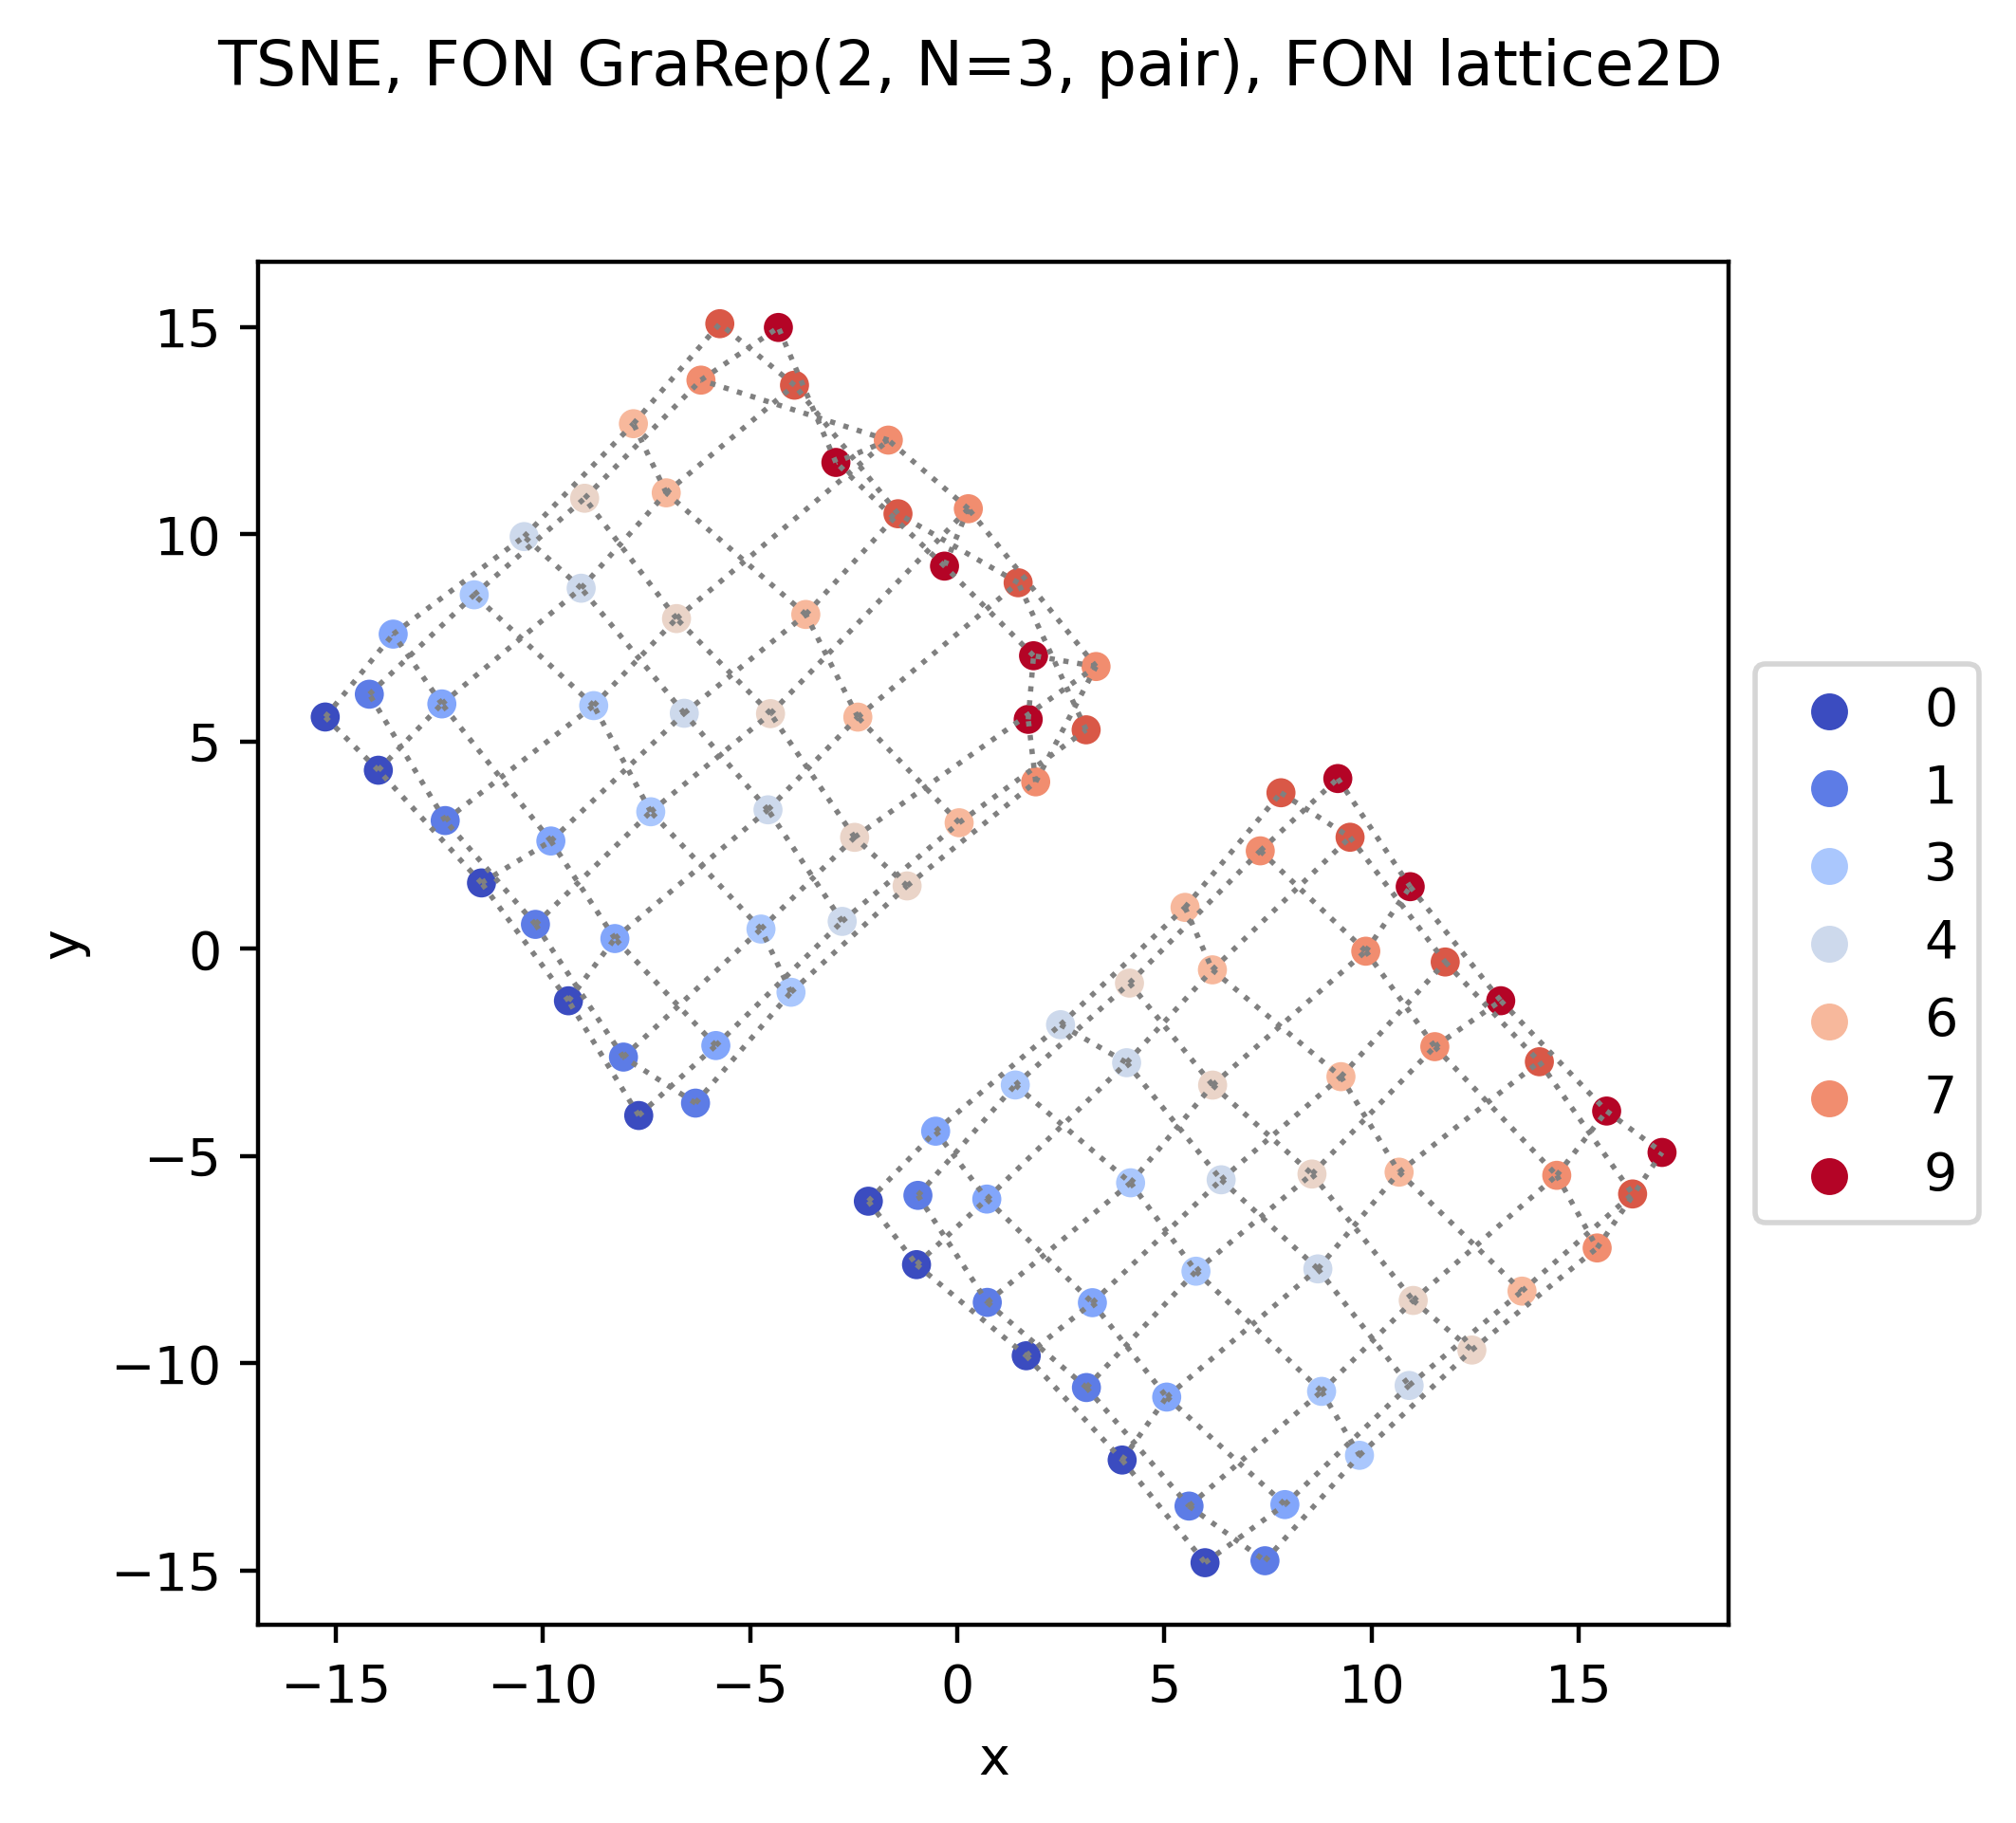

In [26]:
ev_G2_pairs_FON = Lattice2D_EmbeddingView(emb_G2_pairs_FON, use_source=True, edge_distance=2)
vis_G2_pairs_FON = ev_G2_pairs_FON.visualize_TSNE(random_state=16, n_iter=1000, title='TSNE, FON GraRep(2, N=3, pair), FON lattice2D')
vis_G2_pairs_FON.plot1(figsize=(5,5), dpi=400, hue='x_orig')
vis_G2_pairs_FON.save_describe('tmp/fon_tsne_grarep-w2n3_synth_x.png', comment) # figure 4.2 (center, left)

## NetMF(5) - pairwise

In [27]:
emb_N5_pairs = HON_NetMF_Embedding(latgen, 128, pairwise=True)
%time emb_N5_pairs.train(window_size=5, negative=1, optimized=True)
print('effective dimension', emb_N5_pairs.dimension)

Wall time: 81.8 ms
effective dimension 100


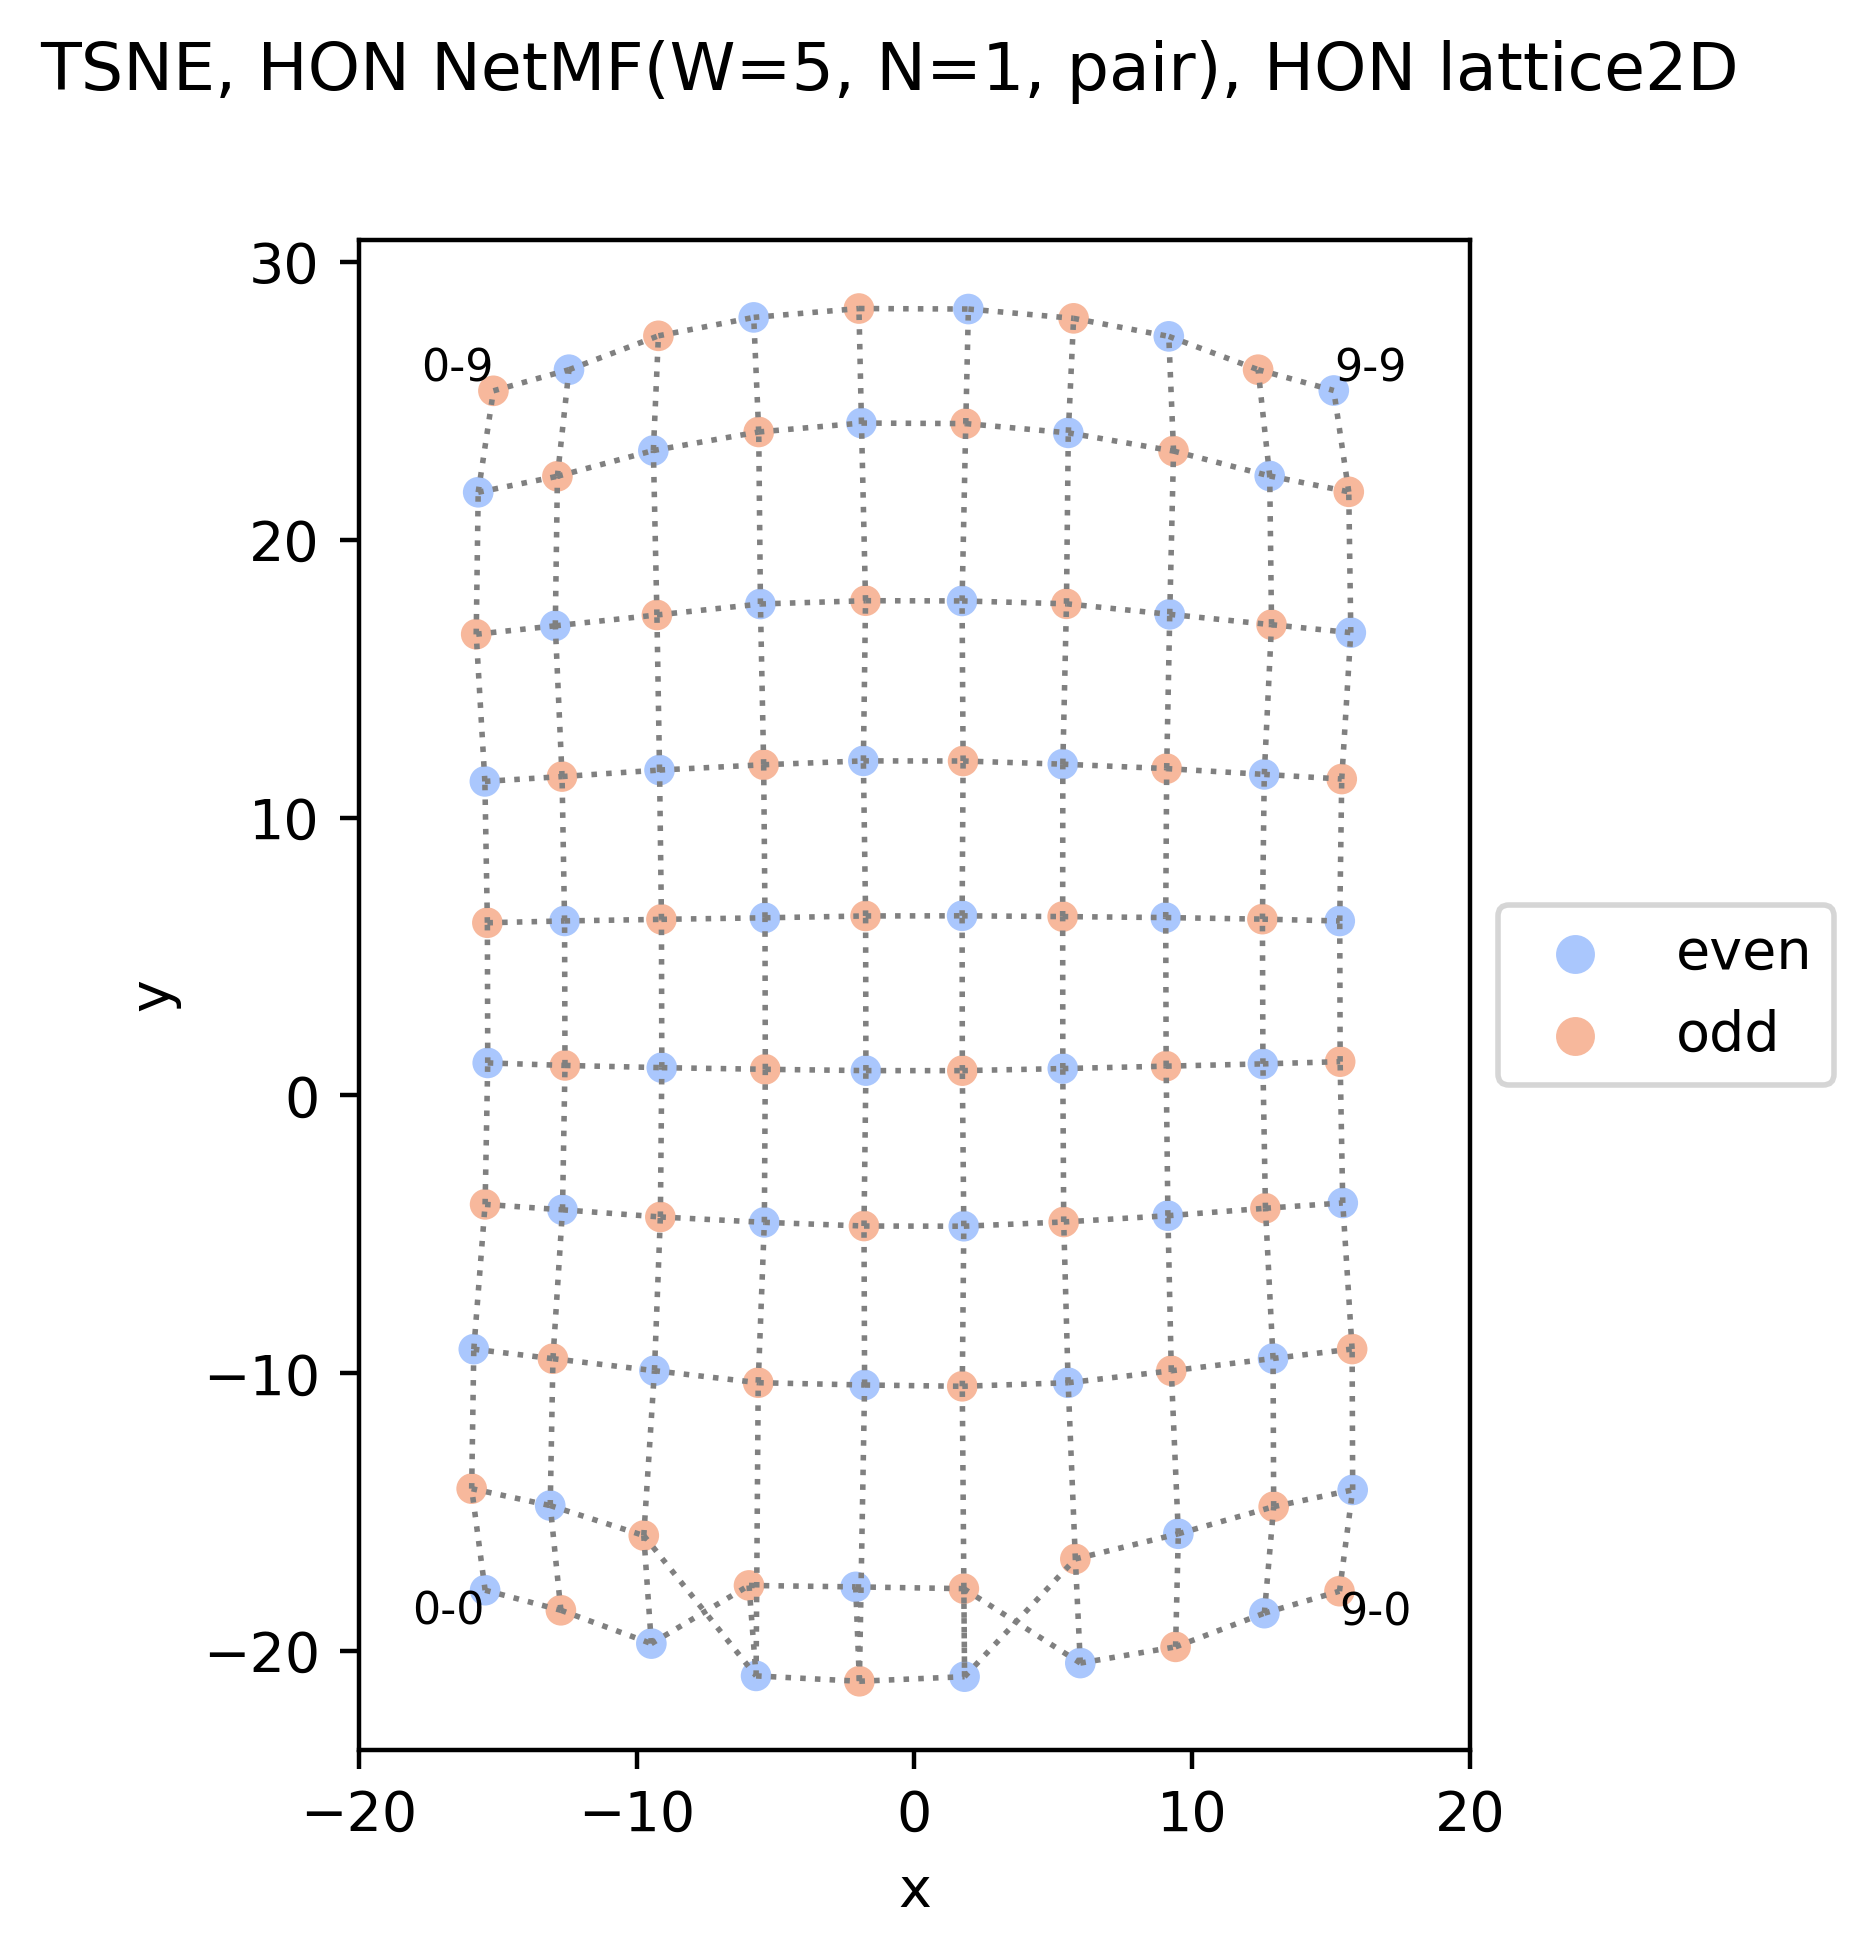

In [28]:
ev_N5_pairs = Lattice2D_EmbeddingView(emb_N5_pairs, use_source=True, edge_distance=1)
vis_N5_pairs = ev_N5_pairs.visualize_TSNE(random_state=12, n_iter=1000, title='TSNE, HON NetMF(W=5, N=1, pair), HON lattice2D')
vis_N5_pairs.plot1(figsize=(5,5), dpi=400, hue='parity')
vis_N5_pairs._figure.gca().set_xlim((-20,20)) # hack
vis_N5_pairs.annotate_node('0-0', ha='right', va='top')
vis_N5_pairs.annotate_node('0-9', ha='right', va='bottom')
vis_N5_pairs.annotate_node('9-0', ha='left', va='top')
vis_N5_pairs.annotate_node('9-9', ha='left', va='bottom')
vis_N5_pairs.save_describe('tmp/tsne_netmf-w5n1-pair_synth_parity.png', comment) # figure 3.2 (left)

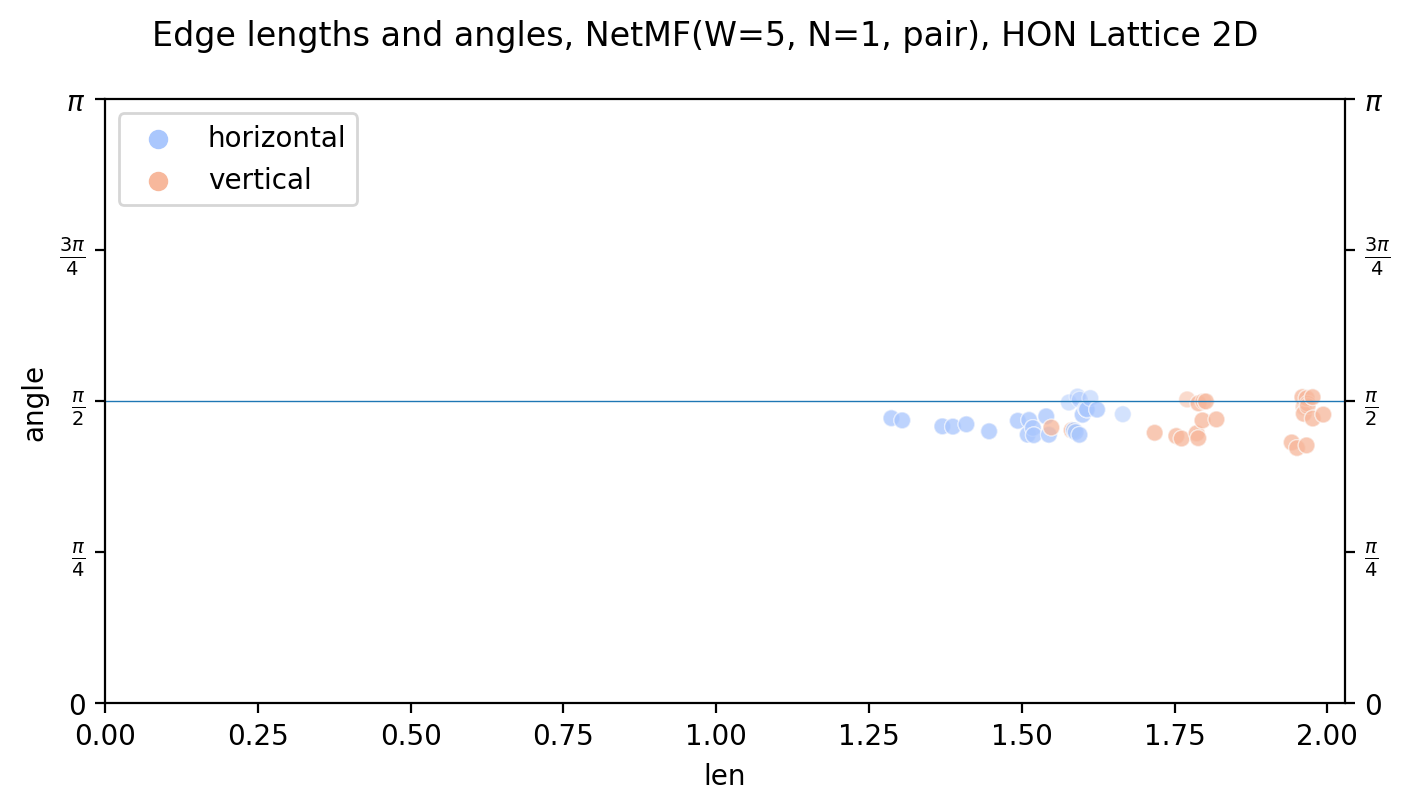

In [29]:
vis_edges = ev_N5_pairs.visualize_edges_len_angle('Edge lengths and angles, NetMF(W=5, N=1, pair), HON Lattice 2D', figsize=(8,4), alpha=0.3)
## vis_edges.plot1() was already called (workaround in visualize_edges_len_angle)
vis_edges.save_describe('tmp/tsne_netmf-w5n1-pair_synth_edge-length-angle.png', comment) # figure 3.4

max_key_len 1
average horizontal edge length 1.5140172316818994
average vertical edge length 1.847282956801455
ratio 0.8195914037465053


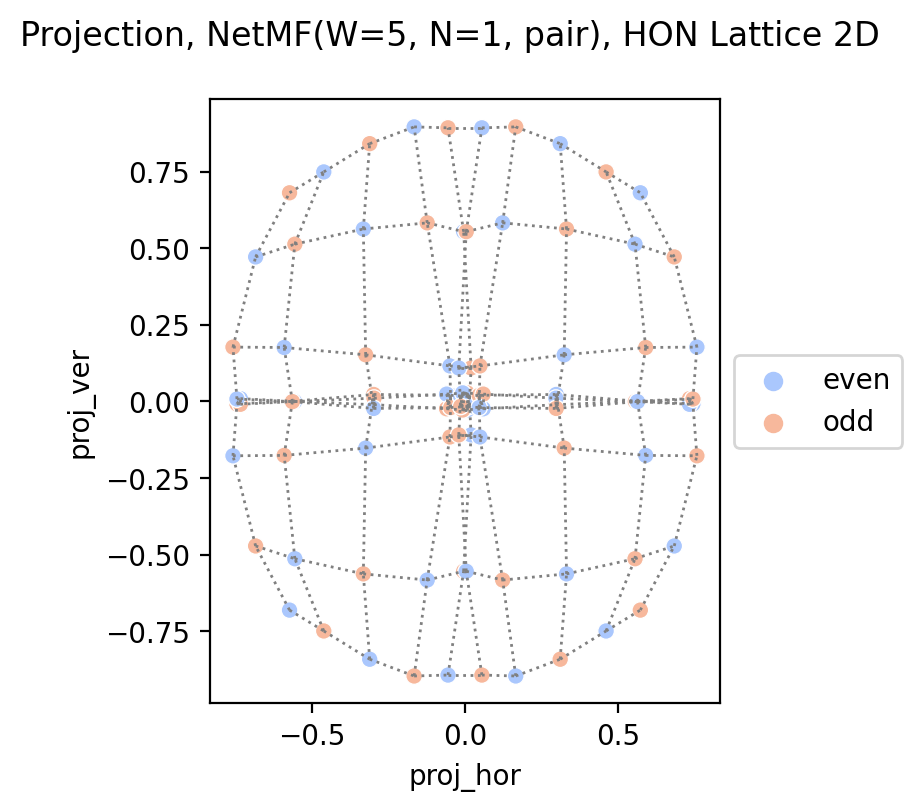

In [30]:
vis_N5_proj=ev_N5_pairs.visualize_proj(title='Projection, NetMF(W=5, N=1, pair), HON Lattice 2D')
vis_N5_proj.plot1(hue='parity')
vis_N5_proj.save_describe('tmp/proj_netmf-w5n1_synth_parity.png', comment) # figure 3.3 (left)

## NetMF(2) - mixed
grid_size=10 does not look great - increase grid or decrease window_size

In [31]:
emb_N = HON_NetMF_Embedding(latgen, 16, pairwise=False)
%time emb_N.train(window_size=2, negative=2)
print('effective dimension', emb_N.dimension)

Wall time: 30.9 ms
effective dimension 16


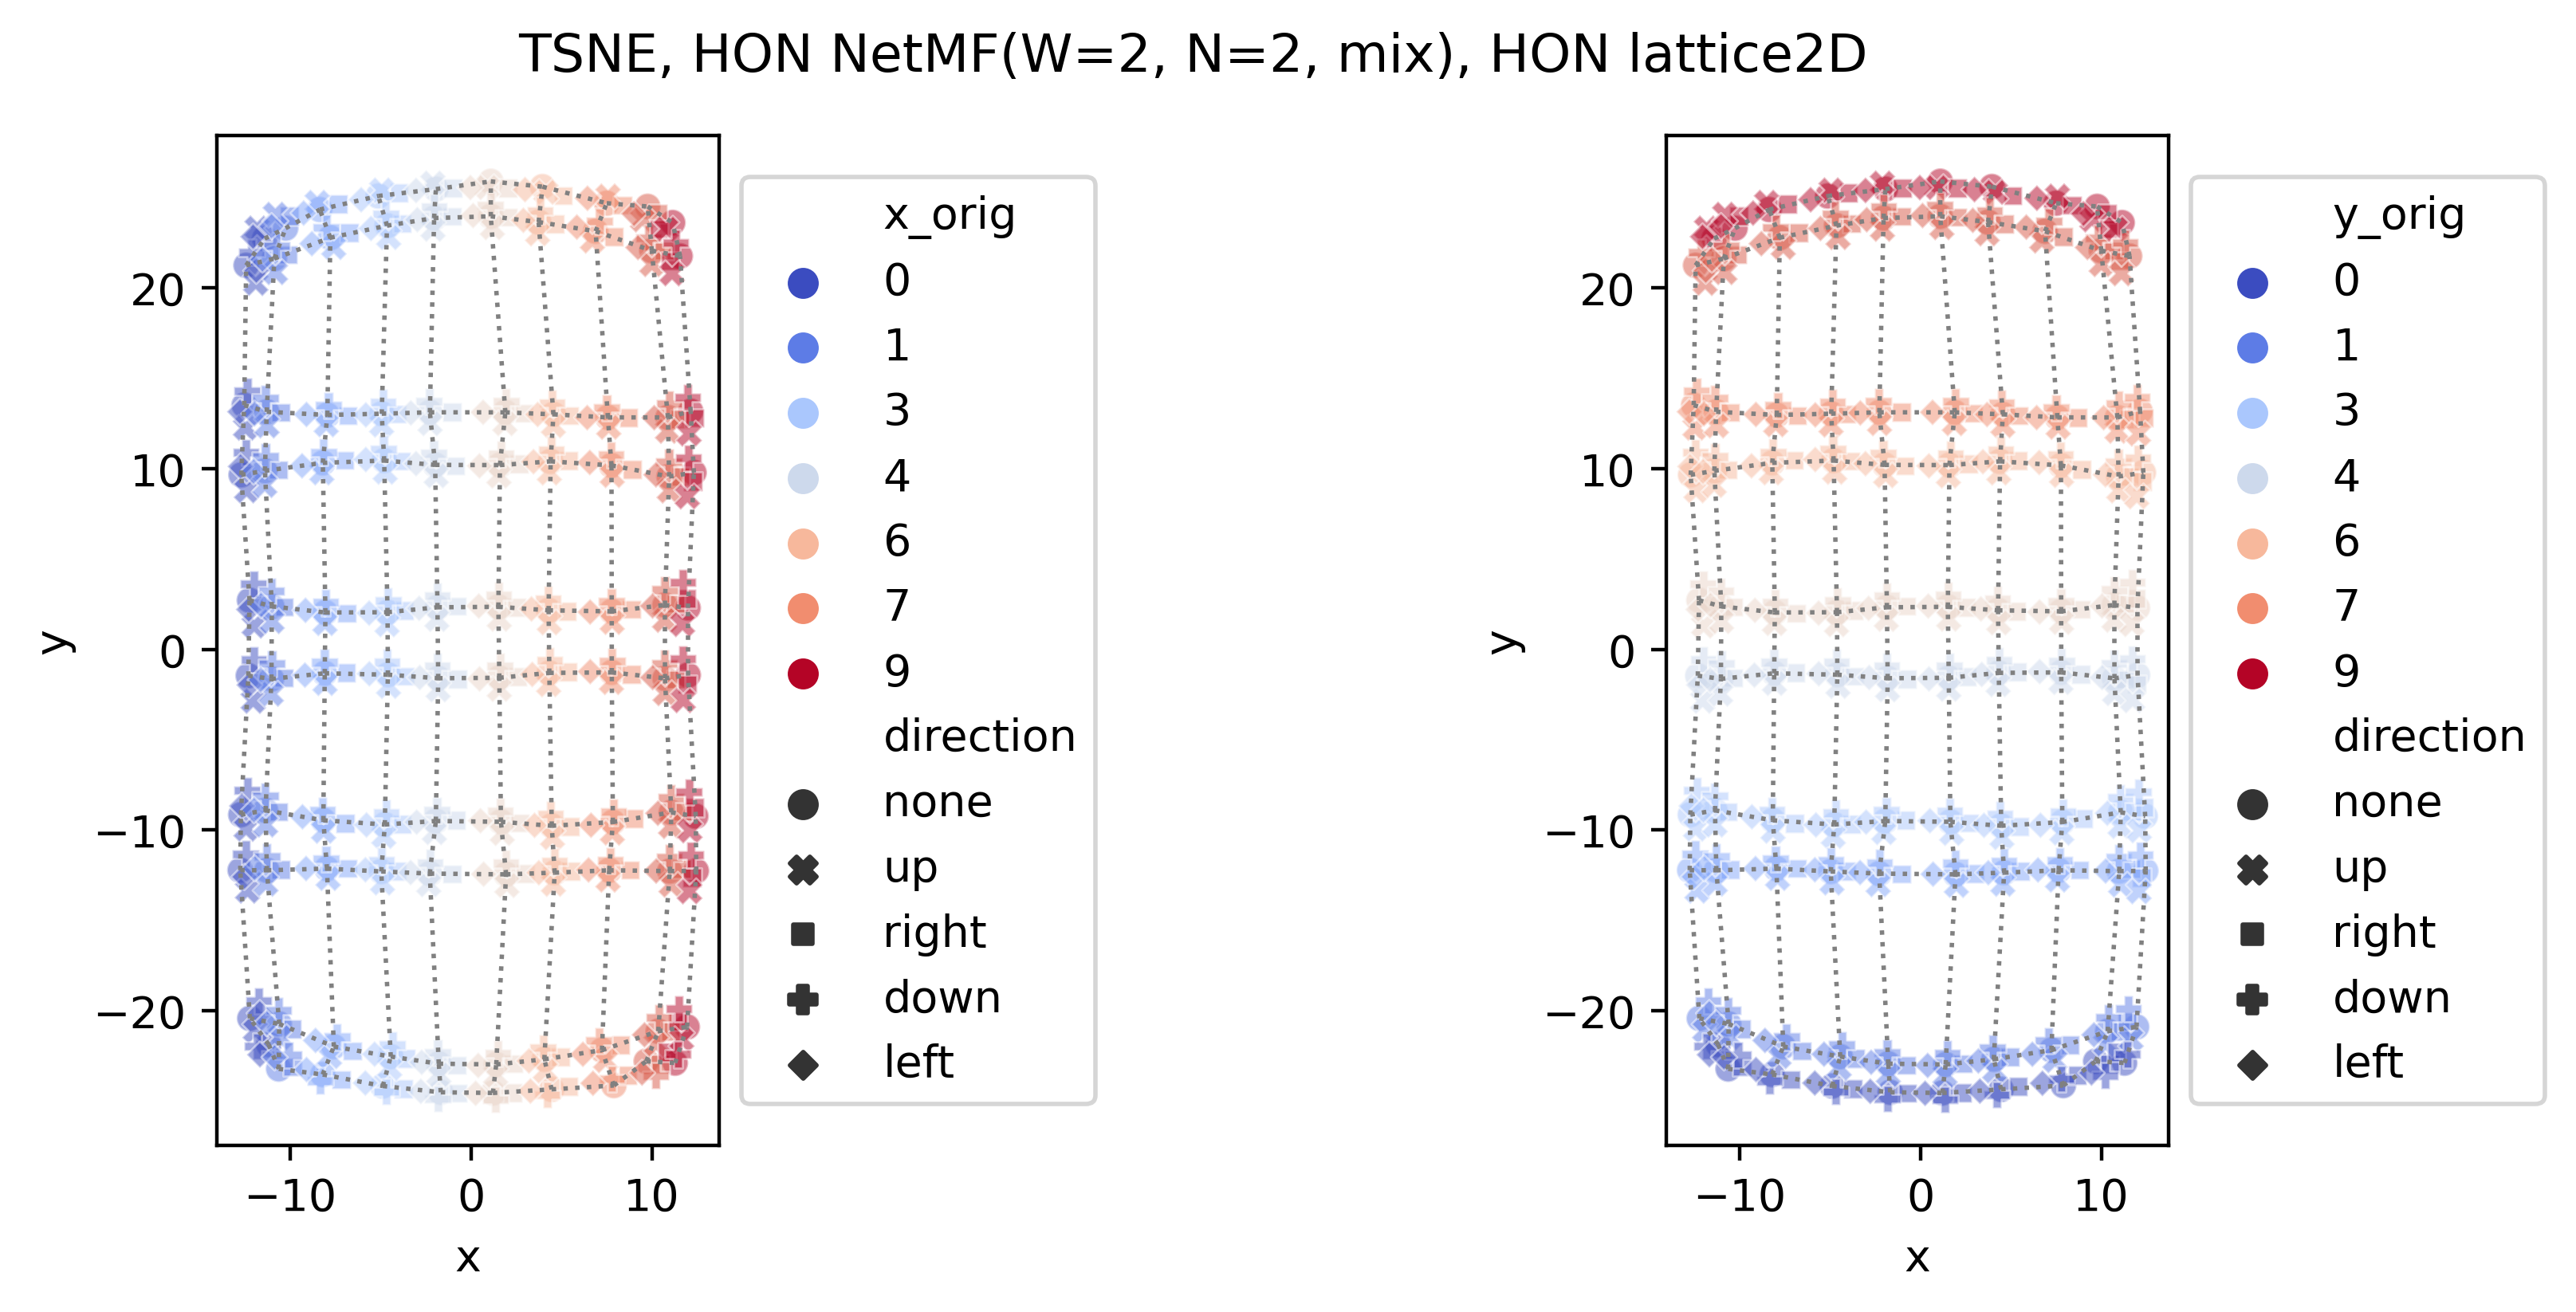

In [32]:
ev_N = Lattice2D_EmbeddingView(emb_N, use_source=True, edge_distance=1)
vis_N = ev_N.visualize_TSNE(random_state=7, n_iter=2000, perplexity=30, title='TSNE, HON NetMF(W=2, N=2, mix), HON lattice2D')
vis_N.plot2(figsize=(9,4), dpi=400, style='direction', alpha=0.5)
# plot not shown in thesis

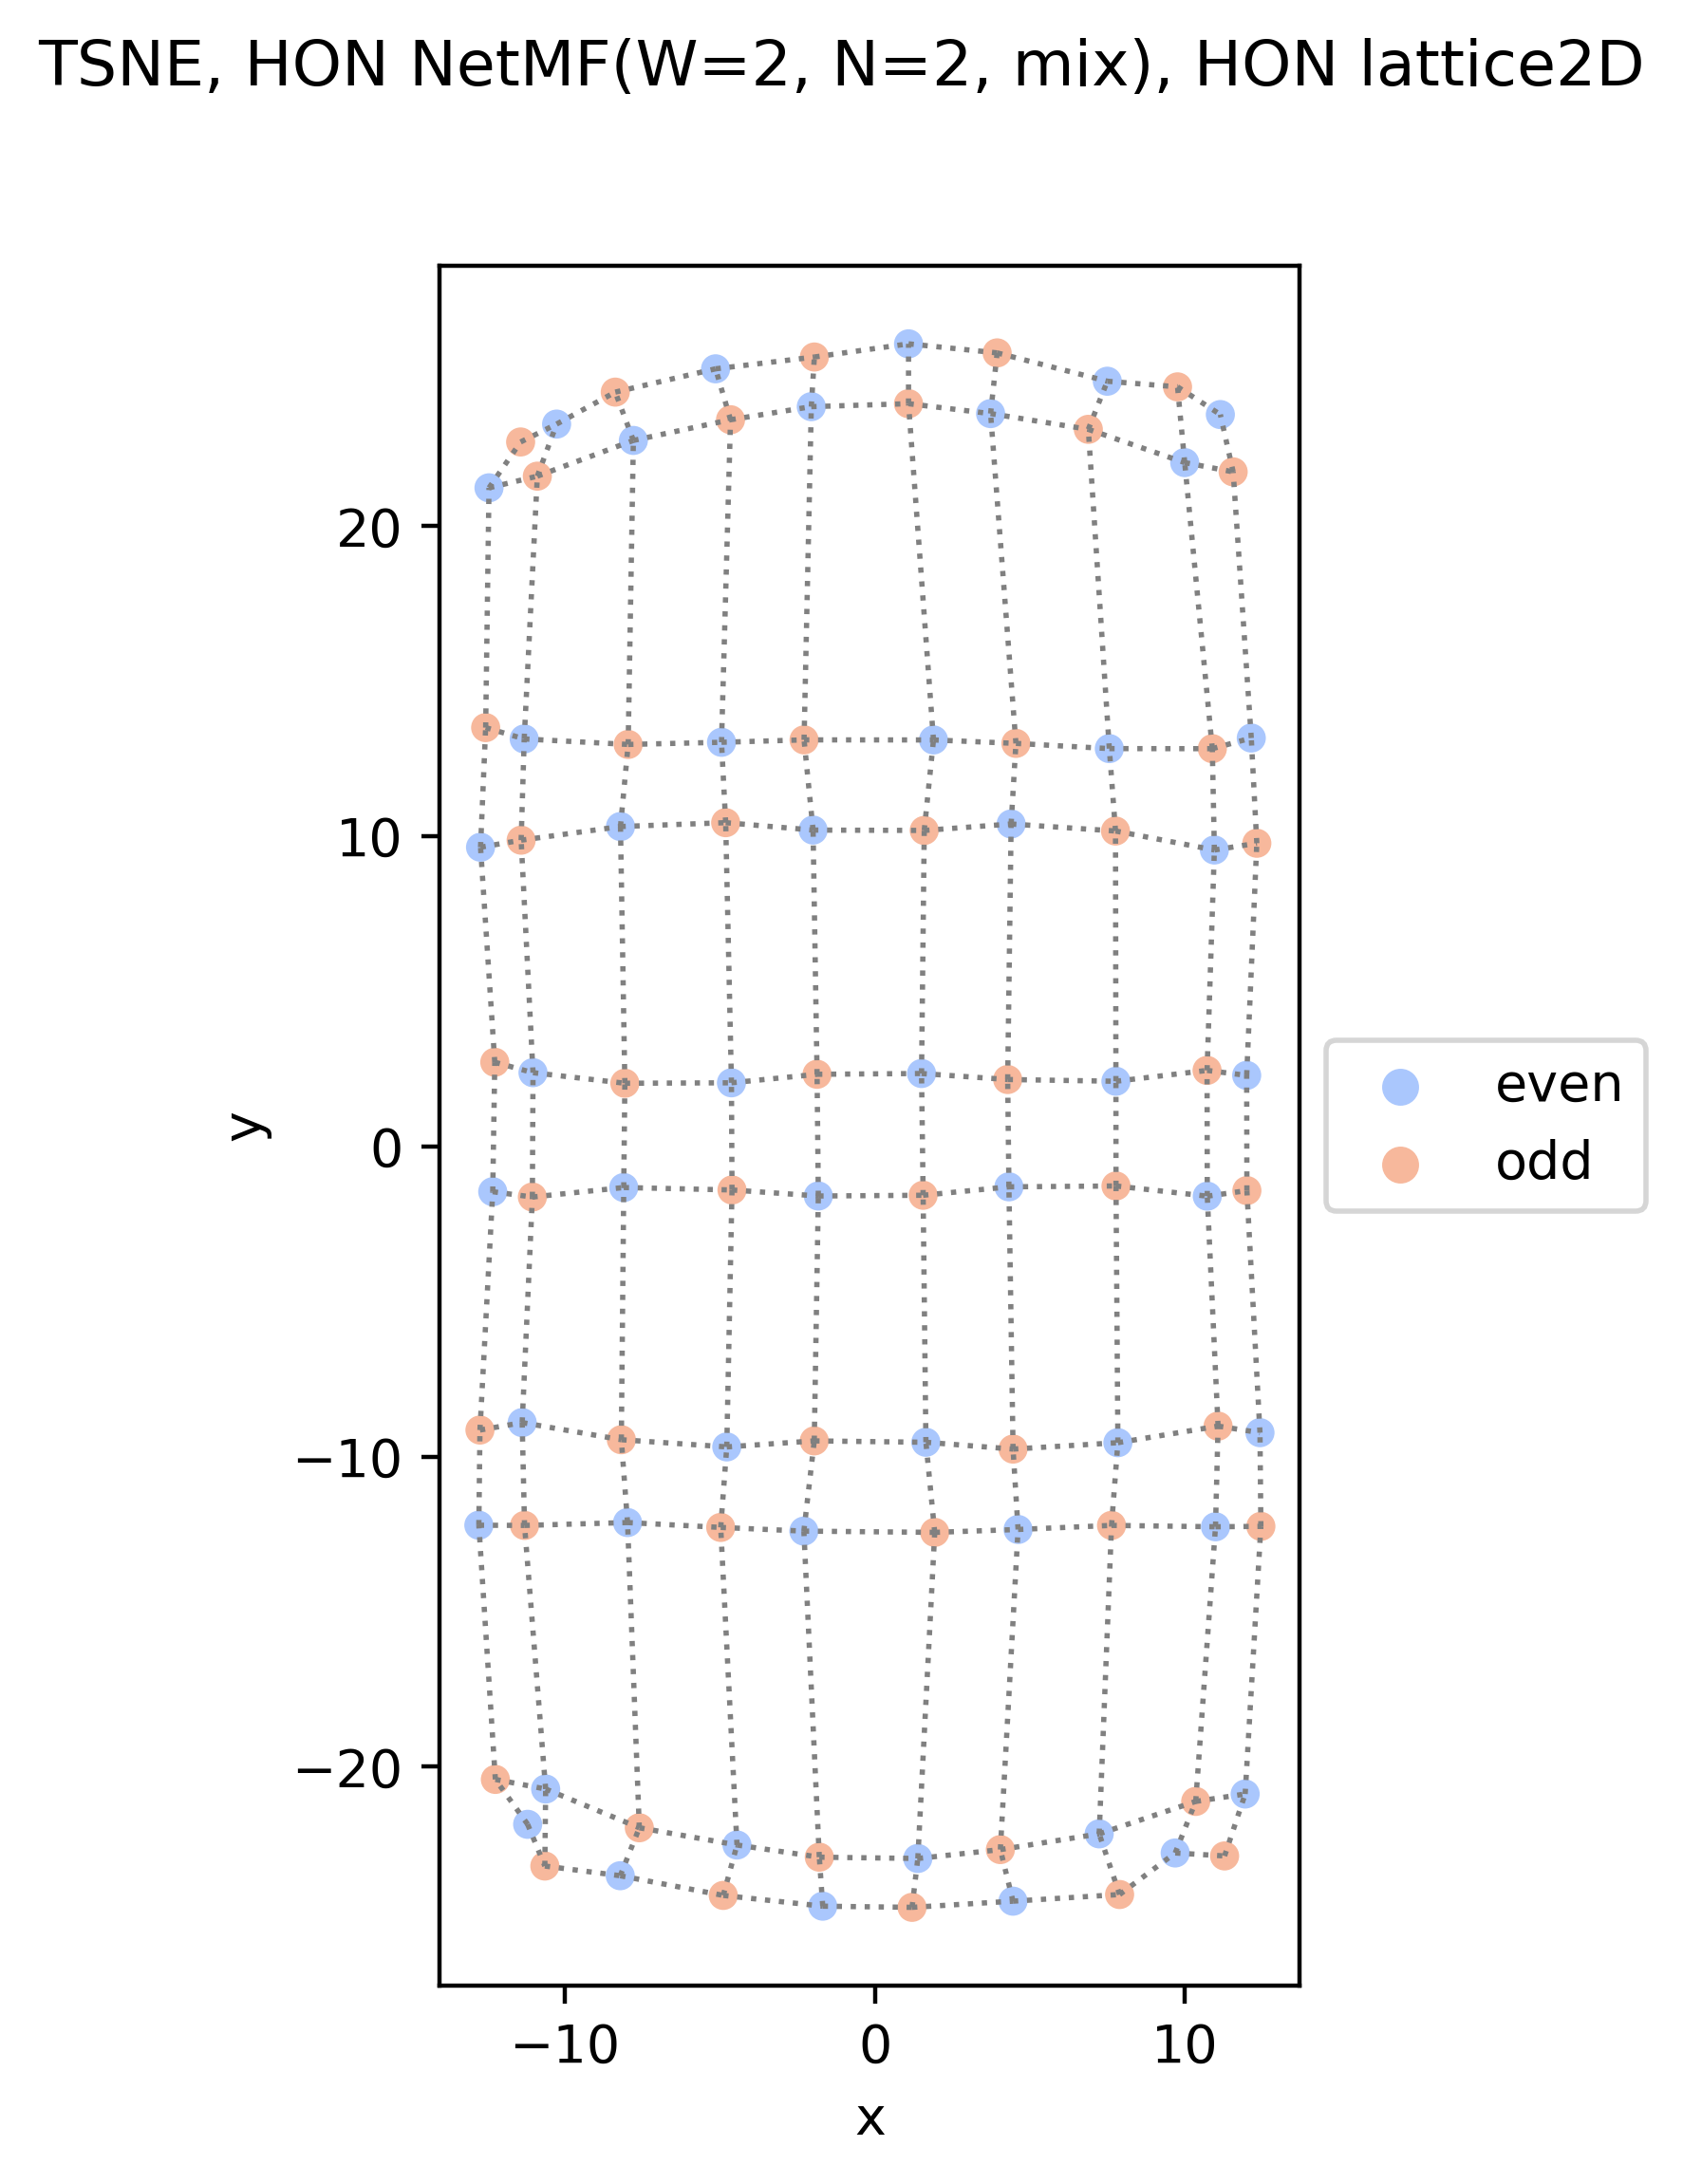

In [33]:
vis_N.plot1(figsize=(6,6), dpi=400, filter_col='key_len', filter_values={1}, hue='parity')
# plot not shown in thesis

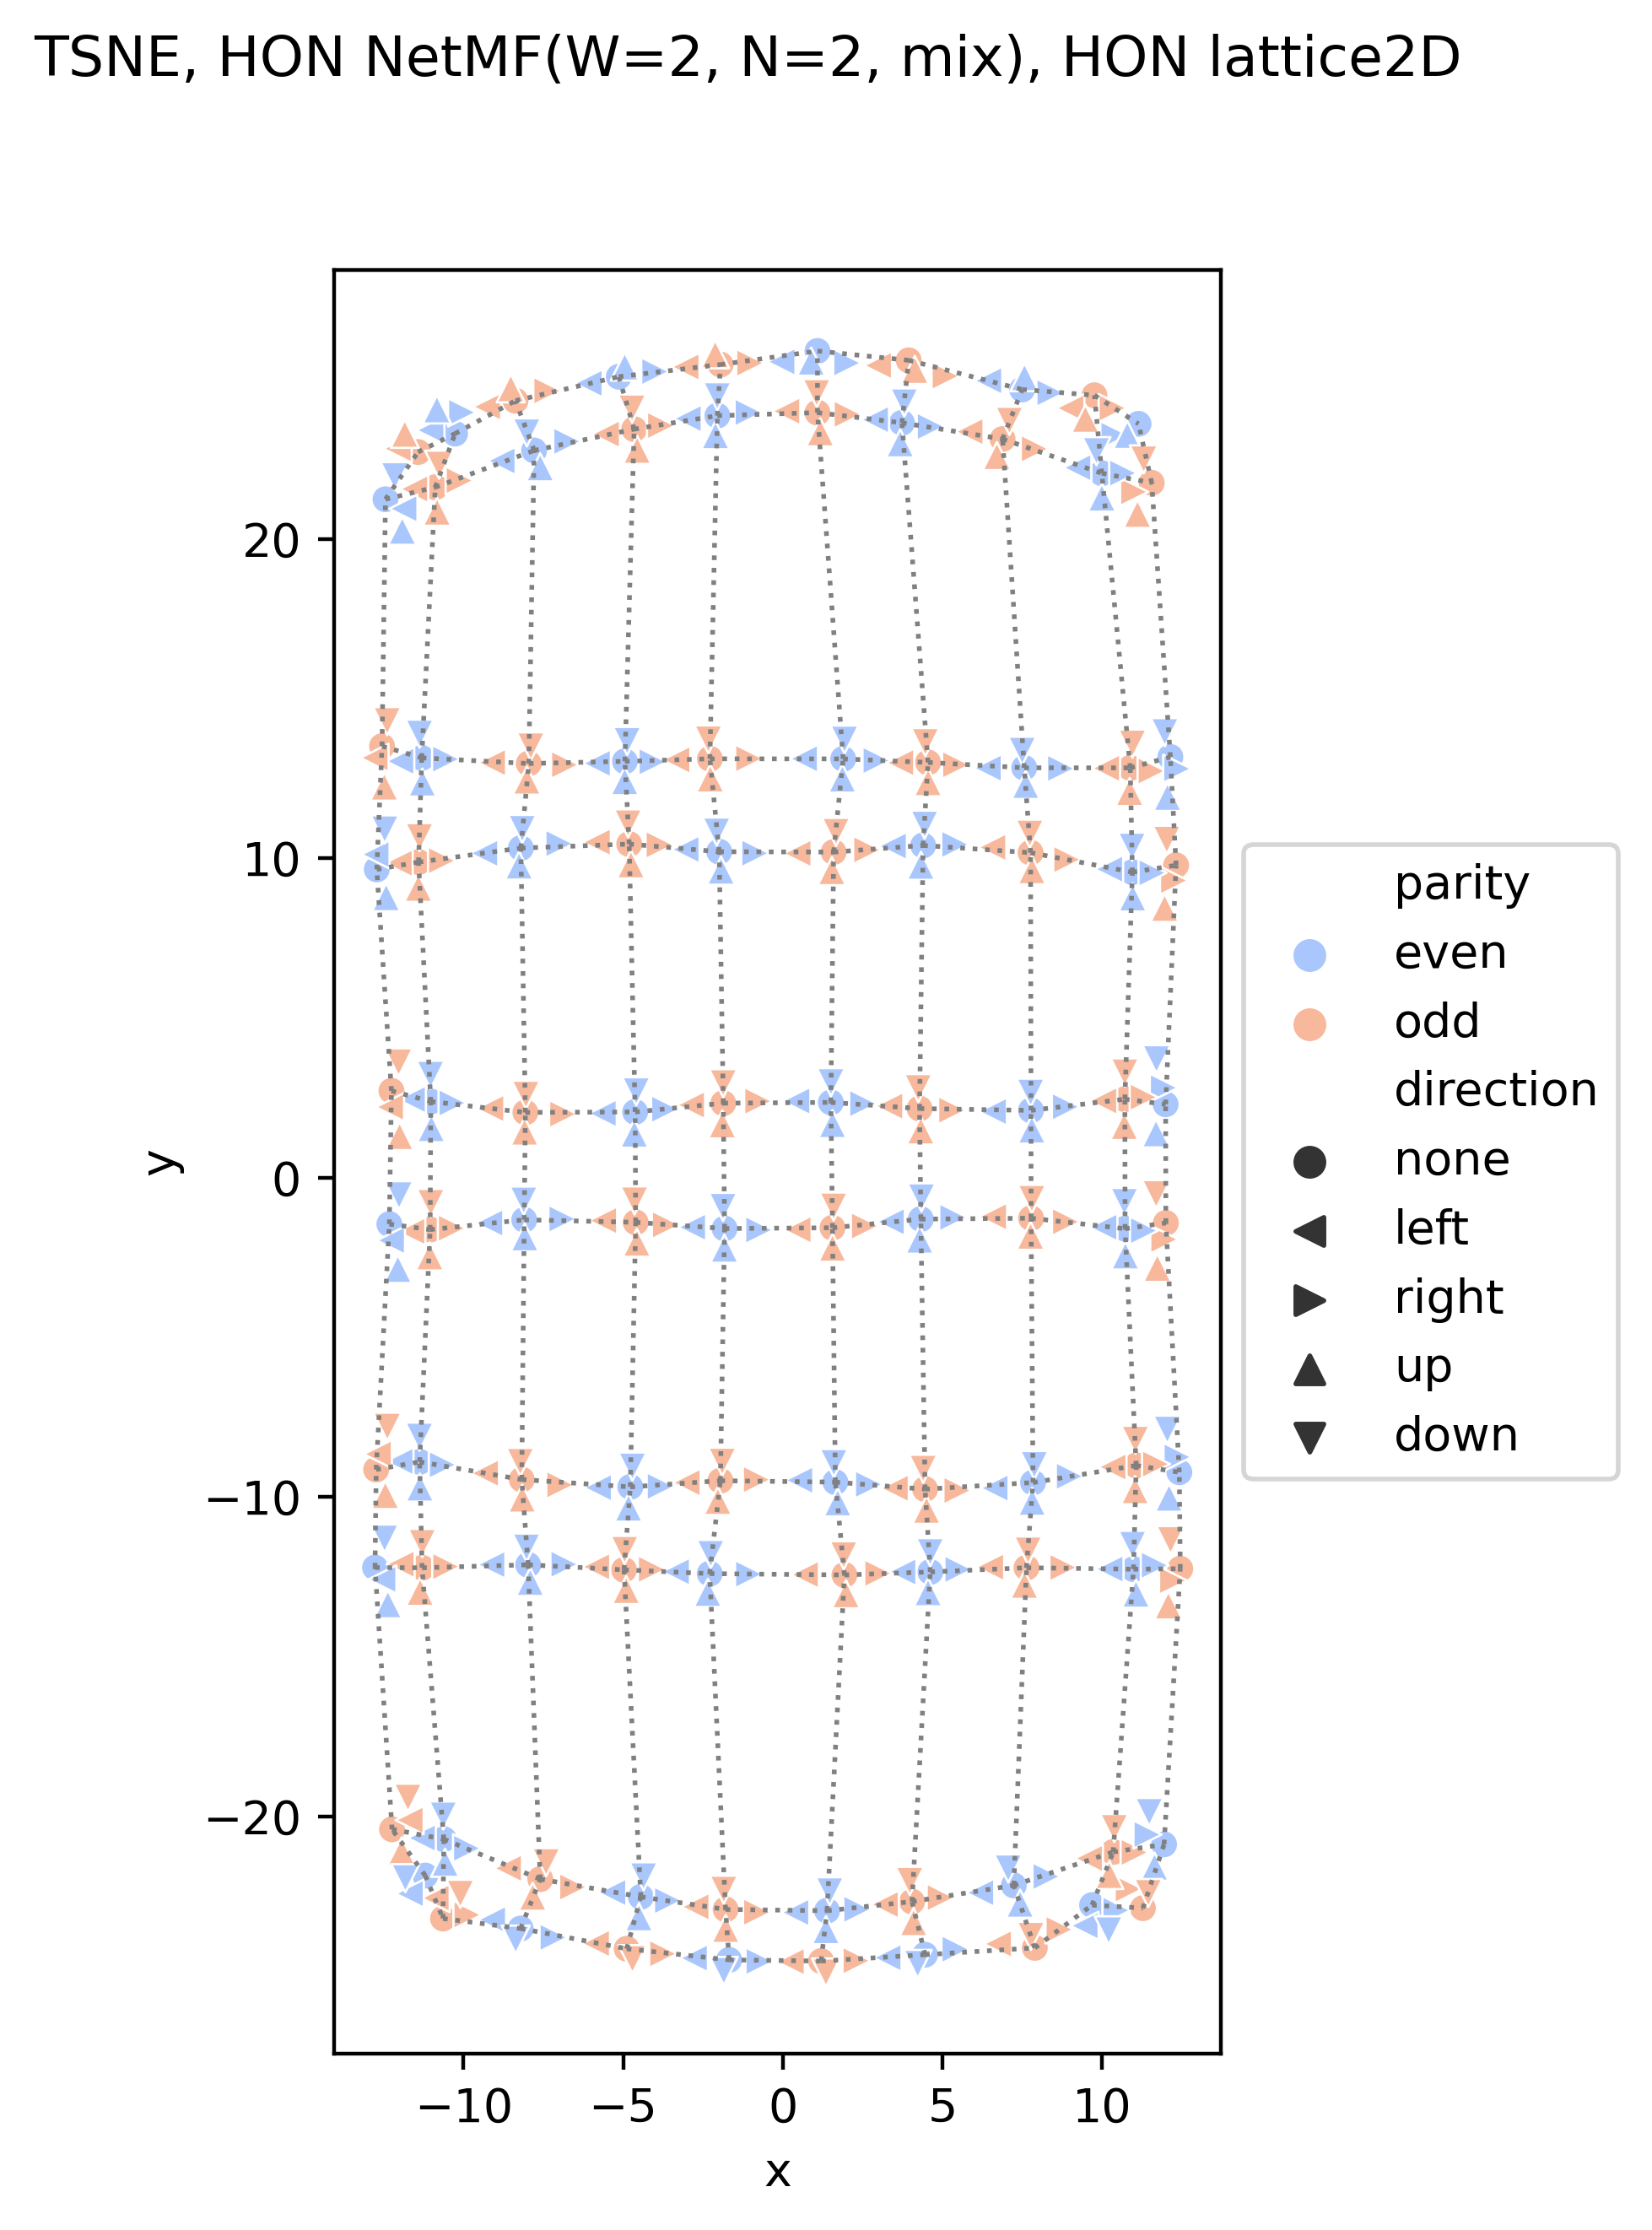

In [34]:
# use edges to display node hierarchy
#vis_N._edges = list( (ev_N.key2str(key), ev_N.key2str(ev_N.node2key(key[-1]))) for key in ev_N.keys if len(key)>1 )
#vis_N.config['edges'] = 'hack...'
# markers
dir_syms = { 'none': 'o', 'left': '<', 'right': '>', 'up': '^', 'down': 'v' }
dir_rank = { k:i for i,k in enumerate(dir_syms.keys()) }
vis_N._data['sort'] = vis_N._data['direction'].map(dir_rank)
vis_N._data.sort_values(['sort'], inplace=True)
#vis_N._data.sort_values(['direction'], inplace=True, key=lambda d:dir_rank[d]) # new in pandas version 1.1.0

vis_N.plot1(figsize=(7,7), dpi=400, style='direction', markers=list(dir_syms.values()), hue='parity')
vis_N.save_describe('tmp/tsne_netmf-w2n2-mix_synth_dir.png', comment) # figure 4.5

paths: Lattice2D(10, omega=0.500000)
embedding: NetMF_paths_source
dim: (180, 4)
embedding columns: ['len', 'angle']
other columns: ['angle360', 'direction']

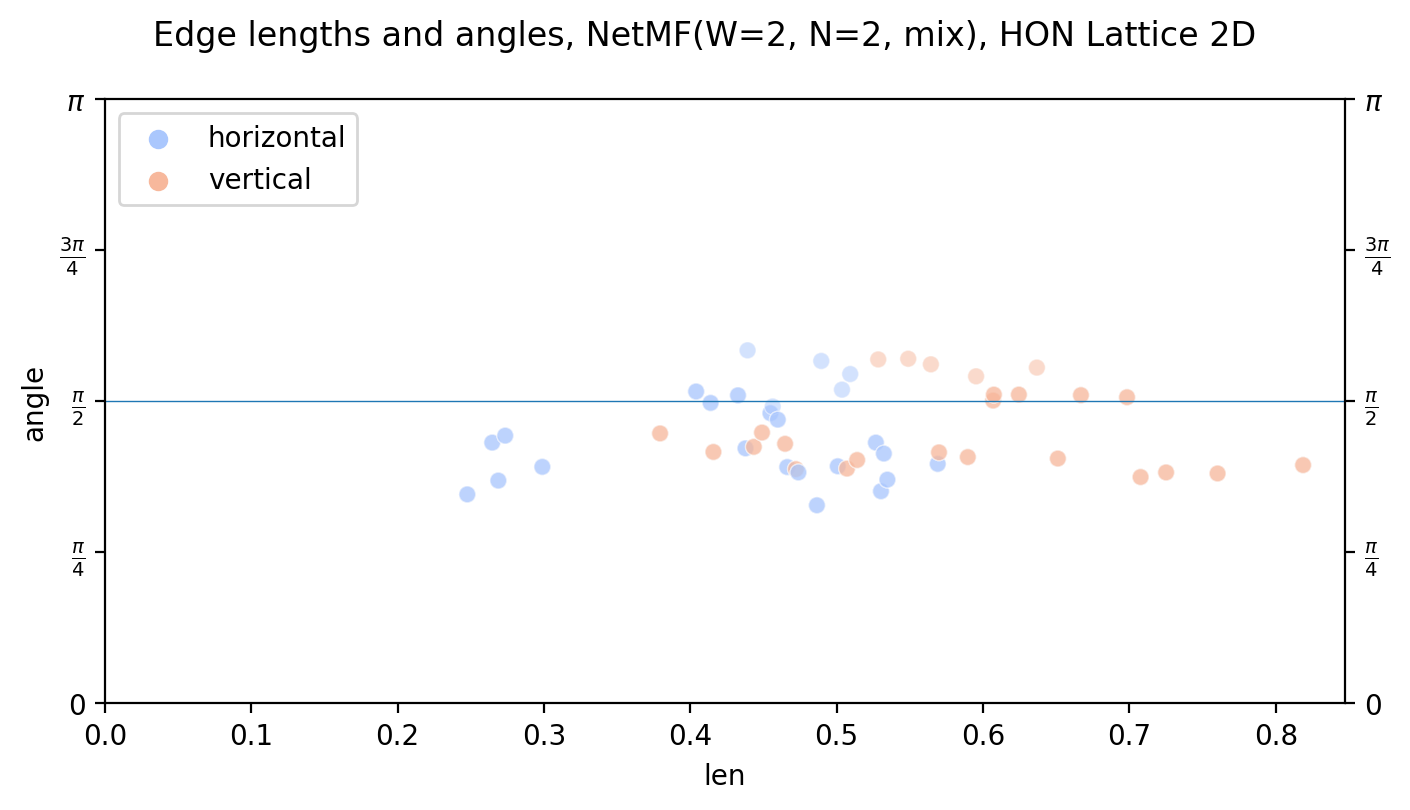

In [35]:
ev_N.visualize_edges_len_angle('Edge lengths and angles, NetMF(W=2, N=2, mix), HON Lattice 2D', figsize=(8,4), alpha=0.3)
# plot not shown in thesis

## Hierarchical Transition Embedding

In [36]:
def plot_obj(title:str, data, filename=None, emb=None):
    y = data['objectives']
    print('Last objective %f' % y[-1])
    total_steps = data['total_steps']
    steps = data['steps']
    previous_steps = total_steps - steps
    x = previous_steps + np.arange(len(y)) * steps / len(y)
    fig = plt.figure(figsize=(6,4),dpi=200)
    ax = fig.gca()
    y_pos = data['objectives_pos']
    y_neg = data['objectives_neg'] * data['negative']
    y_penalty = data['objectives_penalty'] * data['penalty']
    ax.plot(x,data['objectives'], color='black',label='Loss')
    ax.fill_between(x,0,y_pos,label='Positive')
    ax.fill_between(x,y_pos,y_pos+y_neg,label='Negative')
    if data['penalty']>0:
        ax.fill_between(x,y_pos+y_neg,y_pos+y_neg+y_penalty,label='Penalty')
    fig.suptitle(title)
    ax.set_xlabel('steps')
    ax.set_ylabel('loss') # 'objective'
    ax.legend(loc='upper right', ncol=1)
    if filename is not None:
        fig.savefig(filename)
        if emb is not None:
            df = pd.DataFrame(dict(step=x.astype(int),
                loss=obj['objectives'], pos=obj['objectives_pos'], 
                neg=obj['negative']*obj['objectives_neg'], 
                penalty=obj['penalty']*obj['objectives_penalty'])).set_index('step')
            with open(filename + '.txt','w') as f:
                emb.write_config(f, comment=comment, prefix='', sep='\t')
                f.write('\nData:\n')
                f.write(df.to_csv(line_terminator='\n'))

C:\Users\mstud\Anaconda3\envs\thesis\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Wall time: 37.2 s
Last objective 85.666186


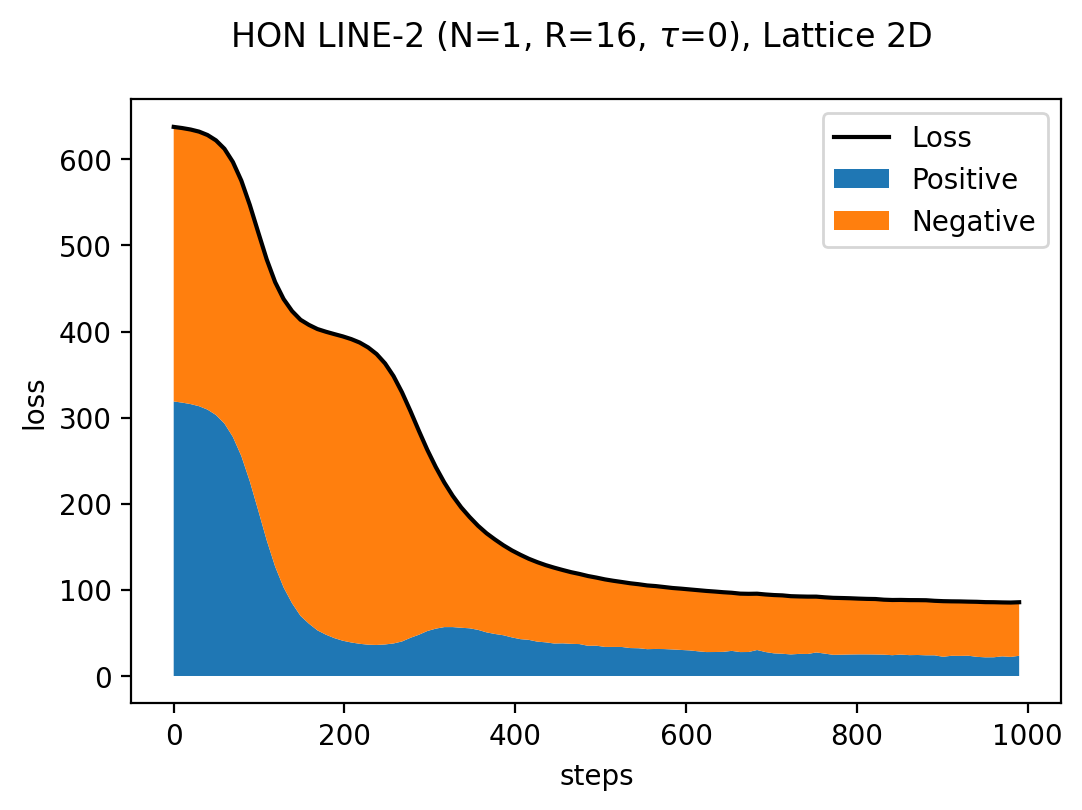

In [37]:
emb_T1 = HON_Transition_Hierarchical_Embedding(latgen, dimension=16, seed=1)
emb_T1_name = 'HON LINE-2 (N=1, R=16, $\\tau$=0), Lattice 2D'
learning_rates = dict(learning_rate_start=0.03, learning_rate_end=0.02)
%time obj = emb_T1.train(steps=1000, negative=1, penalty=0, debug_objective=10, **learning_rates)
plot_obj(emb_T1_name, obj, filename='tmp/loss1.png', emb=emb_T1) # figure B.4 (left)

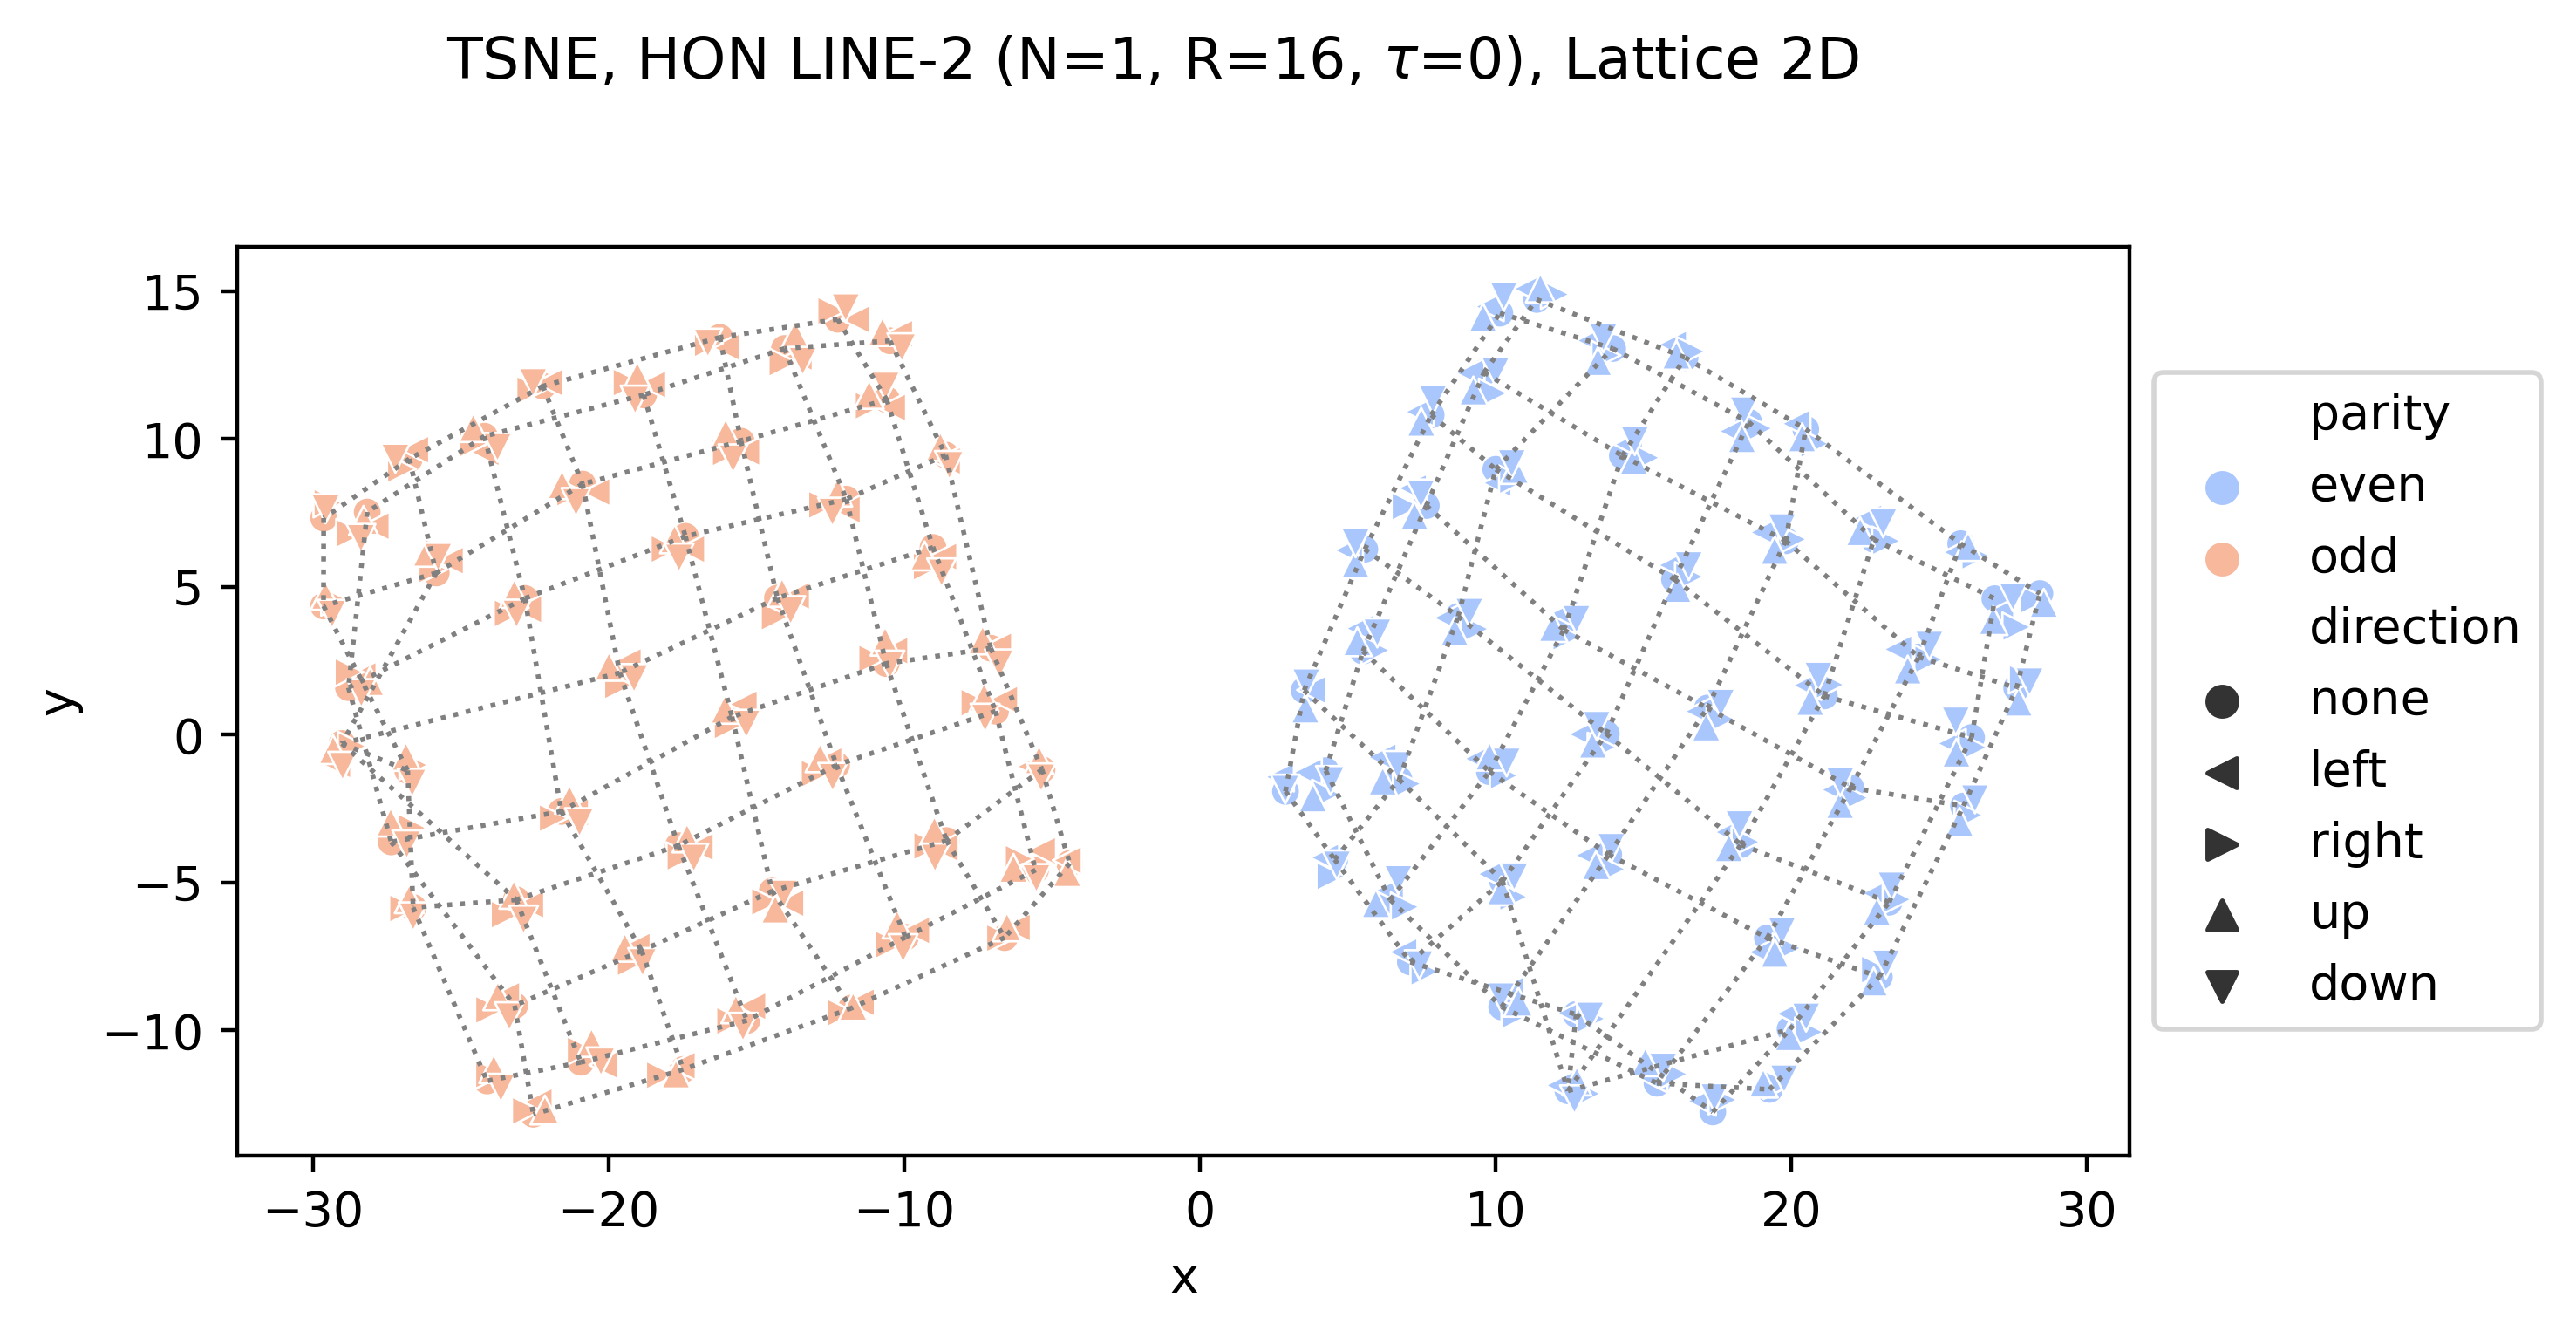

In [38]:
ev_T1 = Lattice2D_EmbeddingView(emb_T1, use_source=True, edge_distance=2)
vis_T1 = ev_T1.visualize_TSNE(random_state=12, n_iter=2000, perplexity=30, title='TSNE, ' + emb_T1_name)
# markers
dir_syms = { 'none': 'o', 'left': '<', 'right': '>', 'up': '^', 'down': 'v' }
dir_rank = { k:i for i,k in enumerate(dir_syms.keys()) }
vis_T1._data['sort'] = vis_N._data['direction'].map(dir_rank)
vis_T1._data.sort_values(['sort'], inplace=True)

vis_T1.plot1(rotate=1.7, figsize=(7,4), dpi=400, style='direction', markers=list(dir_syms.values()), hue='parity')
vis_T1.save_describe('tmp/tsne_hon_line-N1_synth_parity.png', comment) # figure B.3 (left)

In [39]:
if  False:
    ev = ev_T1
    for x in range(20):
        vis = ev.visualize_TSNE(random_state=x, n_iter=1000, learning_rate=200, perplexity=30)
        vis.plot1(figsize=(5,5), dpi=400, hue='parity')

C:\Users\mstud\Anaconda3\envs\thesis\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Wall time: 57.6 s
Last objective 265.507446


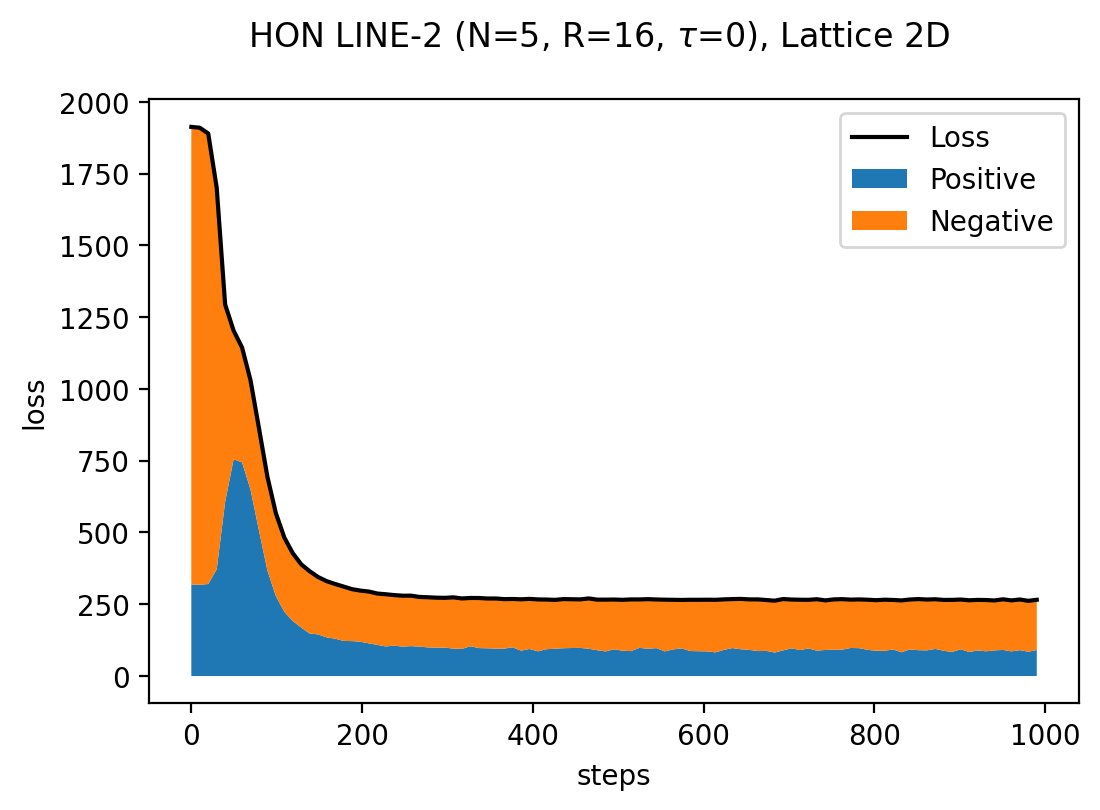

In [40]:
emb_T5 = HON_Transition_Hierarchical_Embedding(latgen, dimension=16, seed=1)
emb_T5_name = 'HON LINE-2 (N=5, R=16, $\\tau$=0), Lattice 2D'
learning_rates = dict(learning_rate_start=0.03, learning_rate_end=0.02)
%time obj5 = emb_T5.train(steps=1000, negative=5, penalty=0, debug_objective=10, **learning_rates)
plot_obj(emb_T5_name, obj5, filename='tmp/loss5.png', emb=emb_T5) # figure B.4 (right)

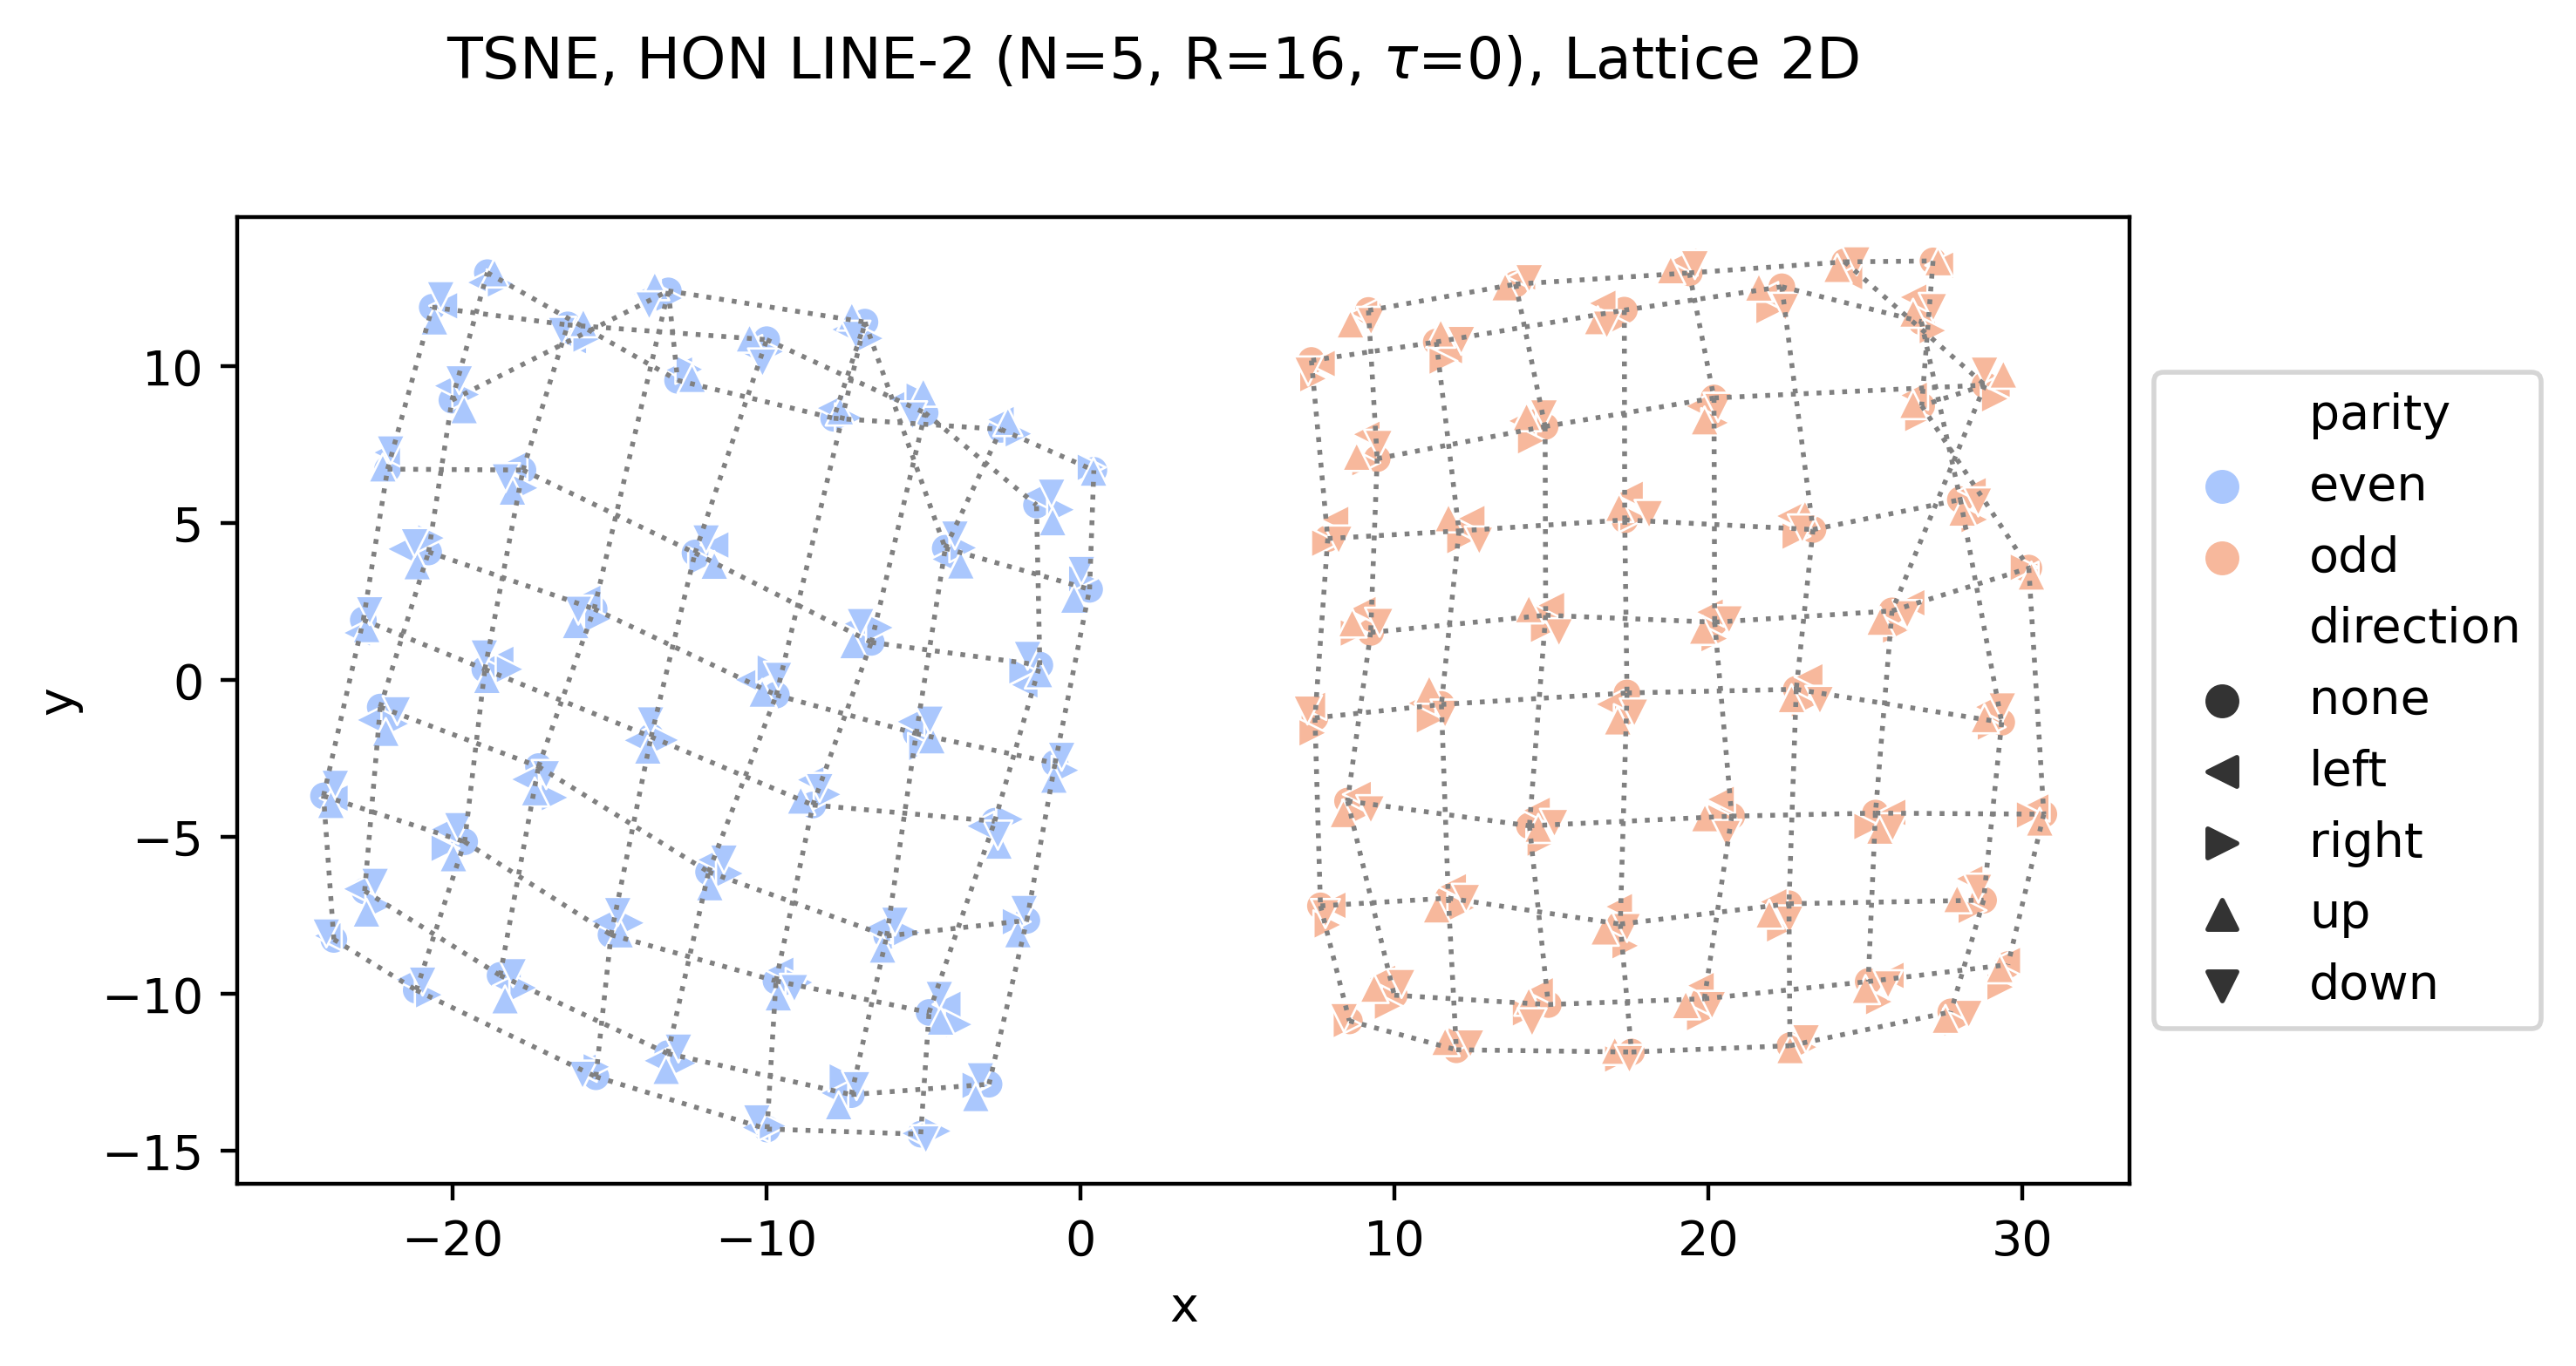

In [41]:
ev_T5 = Lattice2D_EmbeddingView(emb_T5, use_source=True, edge_distance=2)
vis_T5 = ev_T5.visualize_TSNE(random_state=14, n_iter=2000, perplexity=30, title='TSNE, ' + emb_T5_name)
# markers
dir_syms = { 'none': 'o', 'left': '<', 'right': '>', 'up': '^', 'down': 'v' }
dir_rank = { k:i for i,k in enumerate(dir_syms.keys()) }
vis_T5._data['sort'] = vis_N._data['direction'].map(dir_rank)
vis_T5._data.sort_values(['sort'], inplace=True)

vis_T5.plot1(rotate=0.9, figsize=(7,4), dpi=400, style='direction', markers=list(dir_syms.values()), hue='parity')
vis_T5.save_describe('tmp/tsne_hon_line-N5_synth_parity.png', comment) # figure B.3 (right)

C:\Users\mstud\Anaconda3\envs\thesis\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Wall time: 1min 4s
Last objective 267.466980


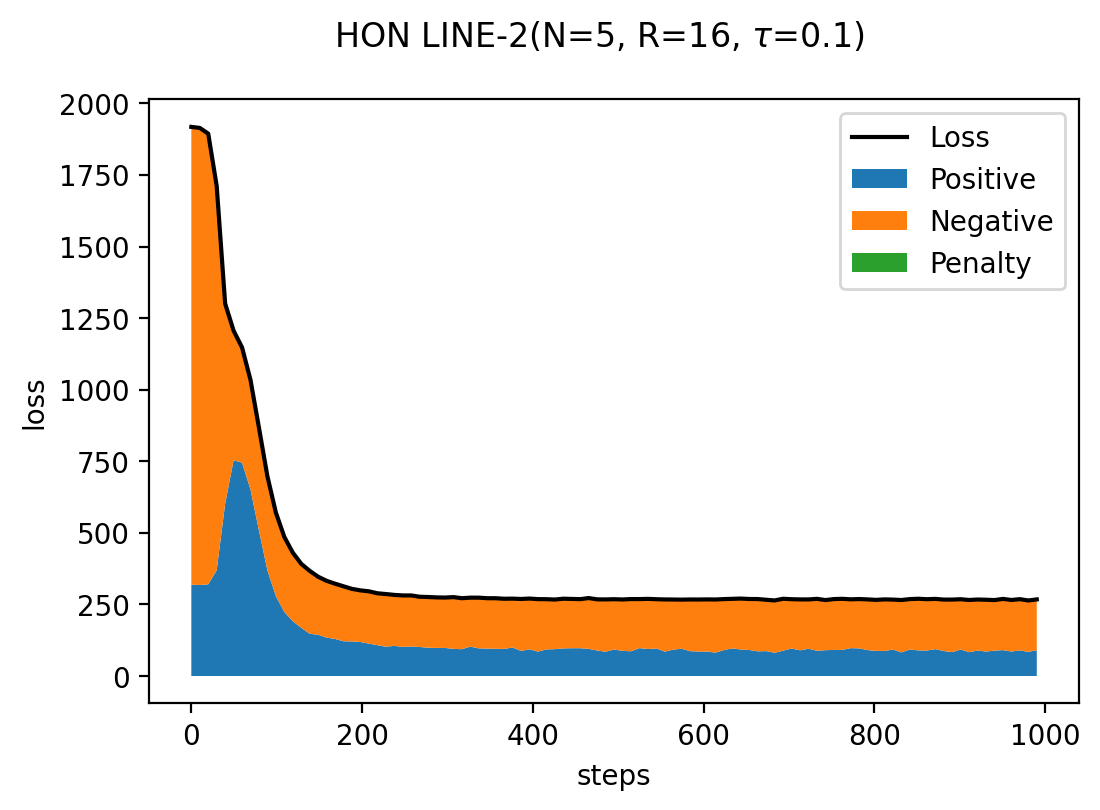

In [42]:
emb_T = HON_Transition_Hierarchical_Embedding(latgen, dimension=16, seed=1)
learning_rates = dict(learning_rate_start=0.03, learning_rate_end=0.02)
%time obj = emb_T.train(steps=1000, negative=5, penalty=0.1, debug_objective=10, **learning_rates)
emb_T_name = f'HON LINE-2(N={obj["negative"]}, R={emb_T.dimension}, $\\tau$={obj["penalty"]})'
plot_obj(emb_T_name, obj)#, filename='tmp/loss.png', emb=emb_T)
# plot not shown in thesis